## 1. Khai báo các thư viện cần thiết

In [1]:
# Khai bao tat ca cac goi, thu vien can thiet
import numpy as np 
import pandas as pd
import os
from tabulate import tabulate
import time
import pickle
import textwrap

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.family'] = 'DejaVu Sans'

%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

import joblib
from sklearn.model_selection import train_test_split, cross_validate, learning_curve, RandomizedSearchCV, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder, PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest, VotingClassifier
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform, euclidean

from xgboost import XGBClassifier

from scipy.stats import boxcox

from IPython.display import display

RANDOM_STATE = 42

## 2. Chuẩn bị dữ liệu

In [2]:
category_order = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 
                      'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 
                      'Obesity_Type_III'] # Cac lop muc tieu (nhan muc tieu du lieu)
# Anh xa cac truong (lop, nhan) muc tieu thanh cac hang so
mapping = {'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2, 'Overweight_Level_II': 3, 'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6}
inverse_mapping = {v: k for k, v in mapping.items()}

In [3]:
# Xem kich thuoc bo du lieu ObesityDataSet.csv
df_org = pd.read_csv('data/ObesityDataSet.csv')
print(df_org.shape)

(2111, 17)


In [4]:
# Xem kich thuoc bo du lieu train.csv khi da xoa cot id
df = pd.read_csv('data/train.csv')
df.drop(columns='id', inplace=True) # Xoa cot id
print(df.shape)

(20758, 17)


In [5]:
# Ghep 2 bo du lieu tren thanh 1 bo moi
df = pd.concat([df, df_org], ignore_index=True)
print(df.shape)

(22869, 17)


In [6]:
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22864,Female,20.976842,1.710730,131.408528,yes,yes,3.000000,3.000000,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
22865,Female,21.982942,1.748584,133.742943,yes,yes,3.000000,3.000000,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
22866,Female,22.524036,1.752206,133.689352,yes,yes,3.000000,3.000000,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
22867,Female,24.361936,1.739450,133.346641,yes,yes,3.000000,3.000000,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [7]:
# Loai bo hang du lieu trung lap, hang du lieu loi
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)
print(df.shape)

(22845, 17)


In [8]:
# Kiem tra va dem so hang bi gia tri null trong moi thuoc tinh
df.isnull().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [9]:
# Thong ke cac truong so
df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,22845.000000,22845.000000,22845.000000,22845.000000,22845.000000,22845.000000,22845.000000,22845.000000
mean,23.888513,1.700467,87.793761,2.443675,2.755837,2.027165,0.984585,0.620984
std,5.755338,0.087865,26.363367,0.533392,0.711185,0.608479,0.839728,0.602802
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,20.000000,1.631856,66.000000,2.000000,3.000000,1.755907,0.015860,0.000000
50%,22.815416,1.700000,84.000000,2.393837,3.000000,2.000000,1.000000,0.582840
75%,26.000000,1.763029,111.531208,3.000000,3.000000,2.531984,1.600431,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


### Giải thích các thông số thống kê Các Trường Số
1. **count**: Số lượng giá trị không rỗng (không phải NaN) trong từng cột. 
2. **mean** (Trung bình): Tổng tất cả các giá trị trong cột chia cho **count**. Ví dụ:
3. **std** (Độ lệch chuẩn): Mức độ phân tán của các giá trị so với giá trị trung bình. Độ lệch chuẩn càng cao thì giá trị càng phân tán. 
4. **min** (Giá trị nhỏ nhất): Giá trị thấp nhất của mỗi trường. 
5. **25%** (Phần tư đầu tiên - Q1): Giá trị tại điểm 25% trong tập dữ liệu. 
6. **50%** (Phần tư thứ hai - Q2/Median - Trung vị): Giá trị giữa của tập dữ liệu. 
7. **75%** (Phần tư thứ ba - Q3): Giá trị tại điểm 75% trong tập dữ liệu. 
8. **max** (Giá trị lớn nhất): Giá trị cao nhất của mỗi trường. 

In [10]:
# Thong ke cac truong the loai
df.describe(include='object')

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,NObeyesdad
count,22845,22845,22845,22845,22845,22845,22845,22845,22845
unique,2,2,2,4,2,2,4,5,7
top,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,Obesity_Type_III
freq,11457,18736,20826,19290,22556,22062,16446,18245,4370


### Giải thích thông số thống kê Các trường thể loại
1. **count**: Số lượng giá trị không rỗng trong mỗi cột 
2. **unique**: Số lượng giá trị duy nhất trong mỗi cột.
3. **top**: Giá trị xuất hiện nhiều nhất (phổ biến nhất, Mod) trong mỗi trường. 
4. **freq**: Tần suất xuất hiện của giá trị phổ biến nhất trong mỗi cột. 

In [11]:
# Liet ke ten truong so va truong the loai
numerical_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in df.columns if df[cname].dtype == "object" and cname != 'NObeyesdad']
print('Numerical Columns (Trường số liệu): ', numerical_cols)
print('Categorical Columns (Trường thể loại): ', categorical_cols)

Numerical Columns (Trường số liệu):  ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
Categorical Columns (Trường thể loại):  ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']


In [12]:
unique_counts = df[categorical_cols].nunique()
unique_values = df[categorical_cols].apply(lambda x: x.unique())

# Tao bo du lieu (Khung du lieu) moi voi cac ket qua xu ly
pd.DataFrame({'Number of Unique Values': unique_counts, 'Unique Values': unique_values})

,Number of Unique Values,Unique Values
Gender,2,"[Male, Female]"
family_history_with_overweight,2,"[yes, no]"
FAVC,2,"[yes, no]"
CAEC,4,"[Sometimes, Frequently, no, Always]"
SMOKE,2,"[no, yes]"
SCC,2,"[no, yes]"
CALC,4,"[Sometimes, no, Frequently, Always]"
MTRANS,5,"[Public_Transportation, Automobile, Walking, M..."


## 3. Phân tích & khai phá dữ liệu (EDA)

In [13]:
# Dem so lan xuat hien cua tung loai (nhan) trong NObeyesdad theo thu tu trong category_order
nobeyesdadVC = df.NObeyesdad.value_counts().reindex(category_order)
nobeyesdadVC

NObeyesdad
Insufficient_Weight    2790
Normal_Weight          3364
Overweight_Level_I     2703
Overweight_Level_II    2812
Obesity_Type_I         3261
Obesity_Type_II        3545
Obesity_Type_III       4370
Name: count, dtype: int64

### 3.1. Phân bổ lớp mục tiêu (Biểu đồ tròn)

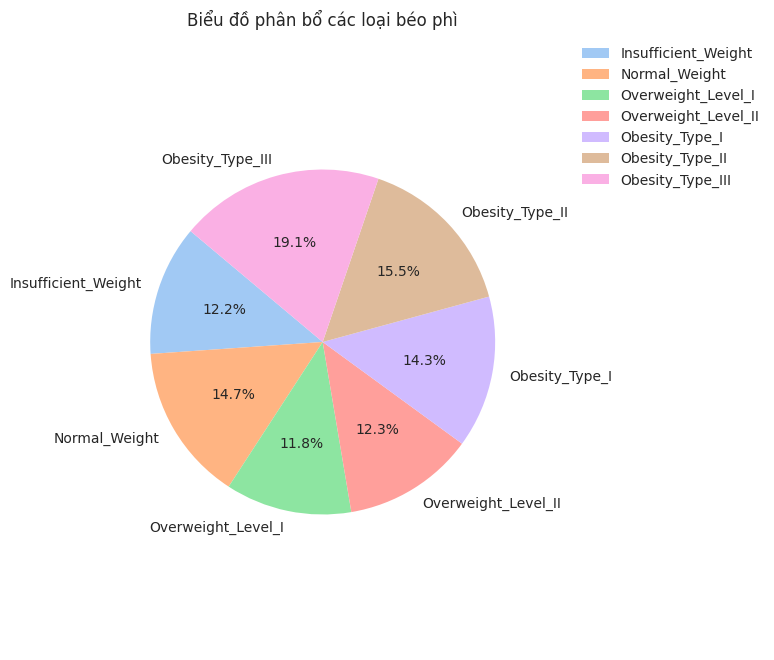

In [14]:
labels = nobeyesdadVC.index.tolist()
sizes = nobeyesdadVC.values.tolist()
colors = sns.color_palette('pastel')[0:10]
# Ve bieu do tron
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, radius=0.7)
plt.legend(loc='upper left', bbox_to_anchor=(0.9, 1))
plt.title('Biểu đồ phân bổ các loại béo phì')
plt.show()

### 3.2. Phân bố của các đặc trưng phân loại

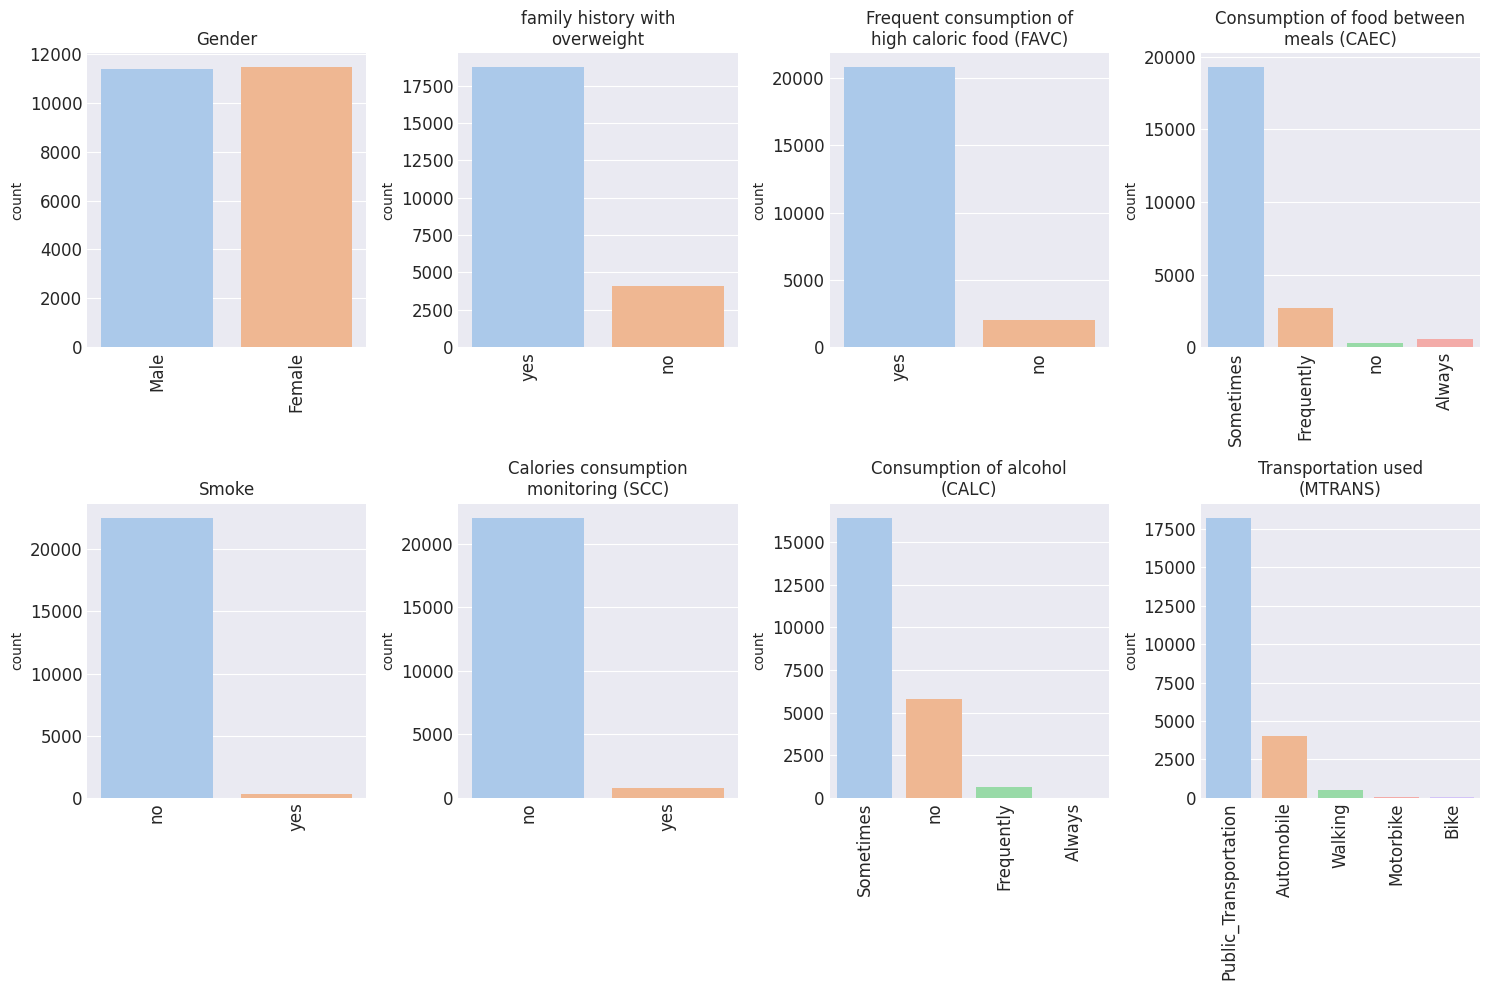

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))
axes = axes.flatten()
num_columns_desc = ['Gender', 'family history with overweight', 'Frequent consumption of high caloric food (FAVC)', 'Consumption of food between meals (CAEC)', 'Smoke', 'Calories consumption monitoring (SCC)',
                'Consumption of alcohol (CALC)', 'Transportation used (MTRANS)']
# Ve cac bieu do cot
for i, column in enumerate(df[categorical_cols].columns):
    sns.countplot(x=column, data=df, ax=axes[i], hue=column, palette='pastel')
    wrapped_title = '\n'.join(textwrap.wrap(f'{num_columns_desc[i]}', width=27))
    axes[i].set_title(wrapped_title)
    axes[i].title.set_size(12)
    axes[i].tick_params(axis='x', labelrotation=90)  
    axes[i].tick_params(axis='both', which='major', labelsize=12)  
    axes[i].set_xlabel('')
plt.tight_layout()
plt.show()

### 3.3. Phân bố của các đặc trưng số liệu

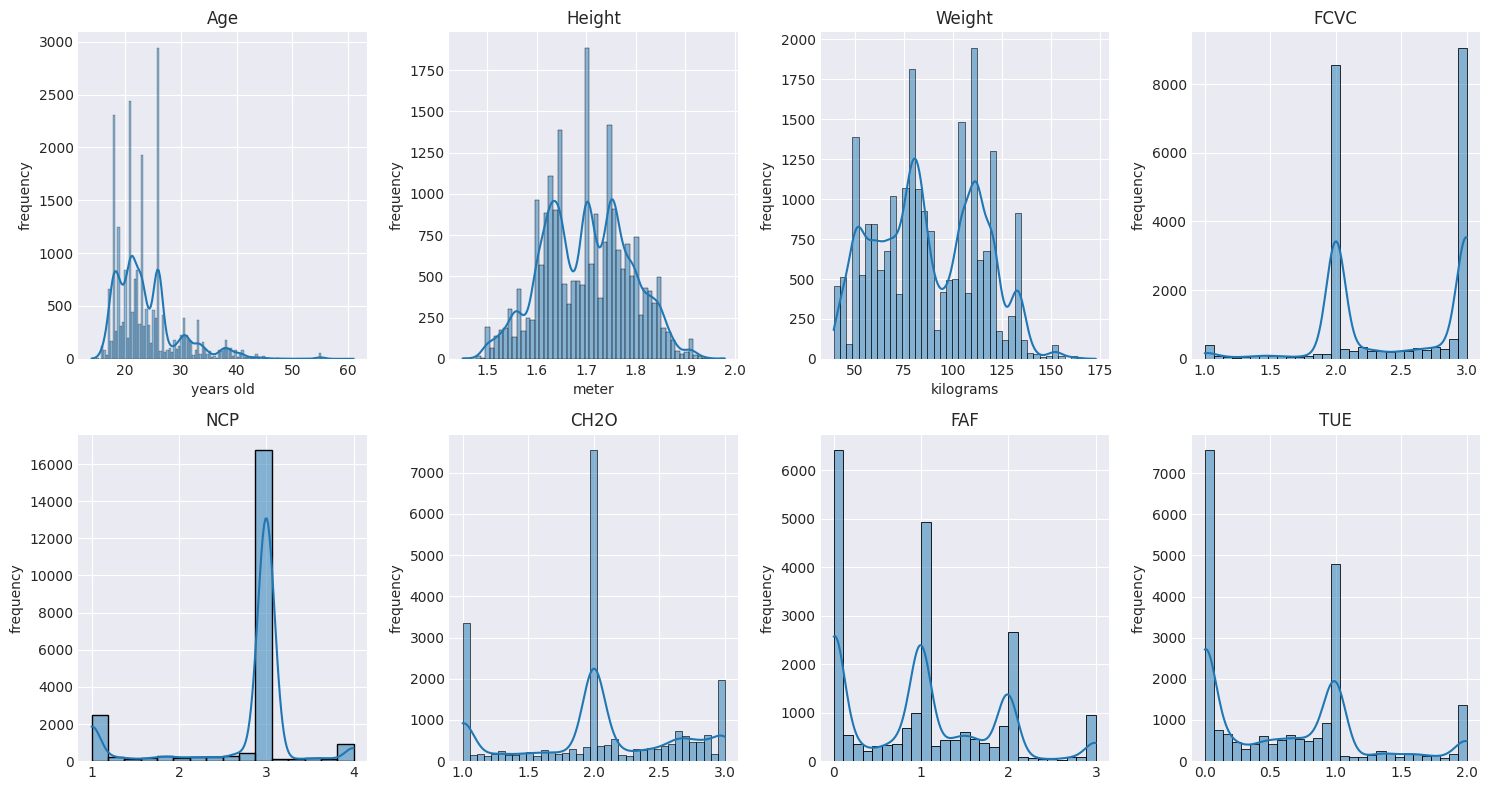

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 4*2))
axes = axes.flatten()
labels = ['years old', 'meter', 'kilograms', '', '', '','', '']
# Ve cac bieu do cot va duong
for i, col in enumerate(numerical_cols):
    sns.histplot(data=df, x=col, palette='pastel', kde=True, ax=axes[i])
    axes[i].set_title(f'{col}')
    axes[i].title.set_size(12)
    axes[i].set_xlabel(labels[i])
    axes[i].set_ylabel('frequency')    
plt.tight_layout()
plt.show()

### 3.4. Phát hiện giá trị ngoại lai cho các cột số liệu

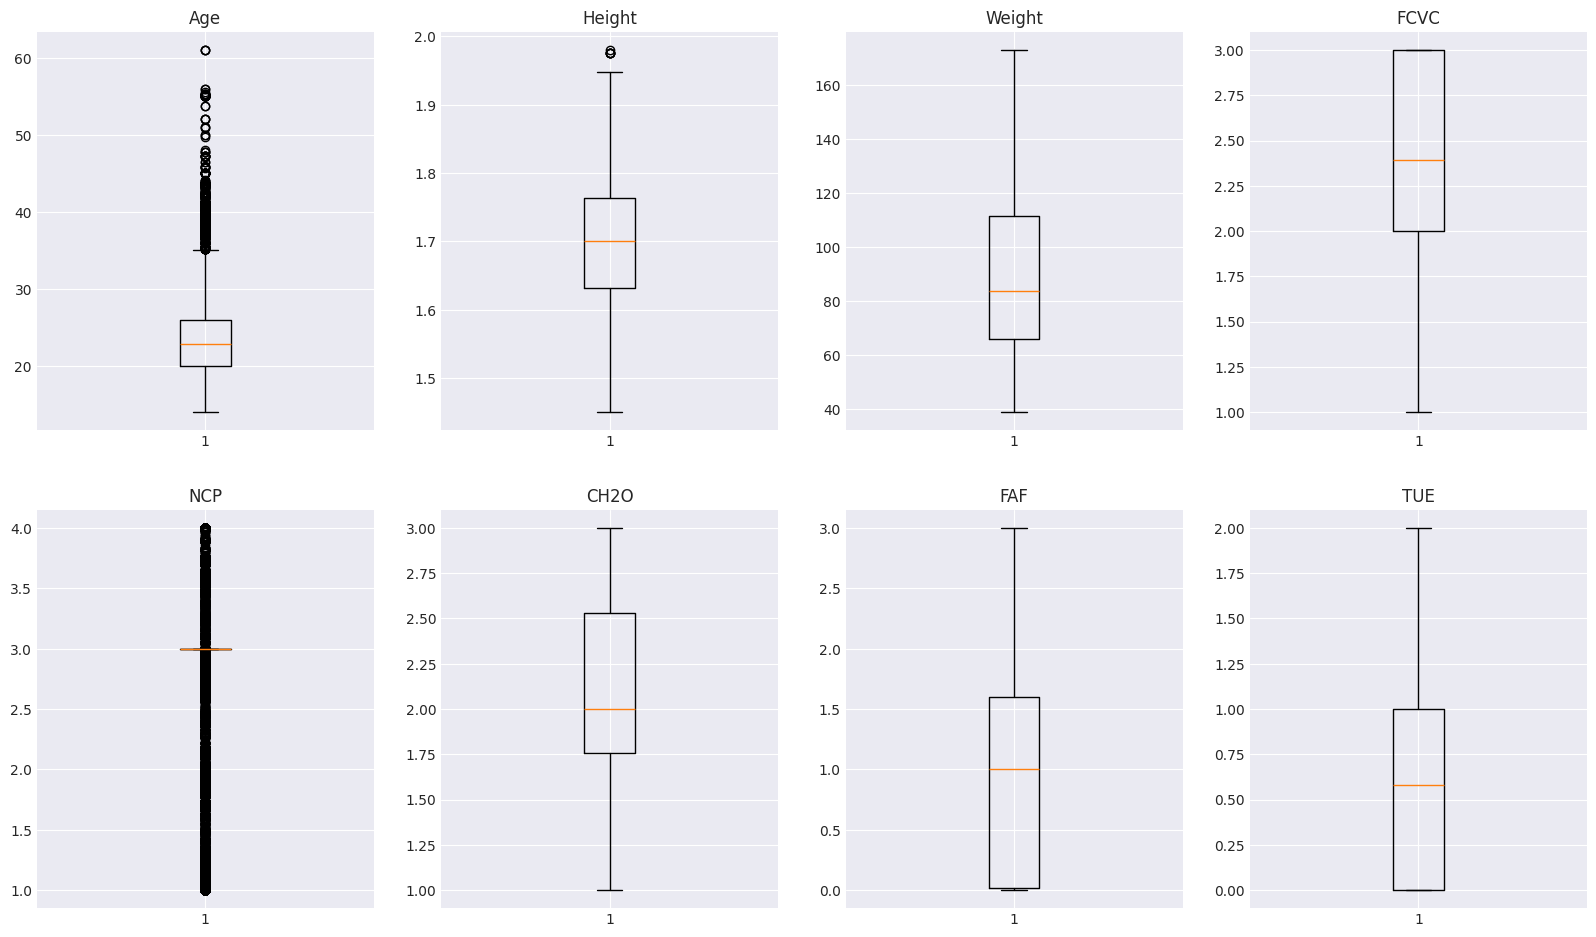

In [17]:
# Truc quan hoa ngoai le bang cach su dung box-plot
plt.figure(figsize=(20,30))
i = 1
columns_desc = ['Age', 'Height', 'Weight', 'Frequency of consumption of vegetables', 'Number of main meals', 'Consumption of water daily',
                'Physical activity frequency', 'Time using technology devices']
for col in numerical_cols:
    plt.subplot(5, 4, i)
    plt.boxplot(df[col], whis=1.5)
    plt.title(f'{col}')
    i += 1

### 3.5. Mối quan hệ giữa các đặc trưng số liệu và các lớp mục tiêu

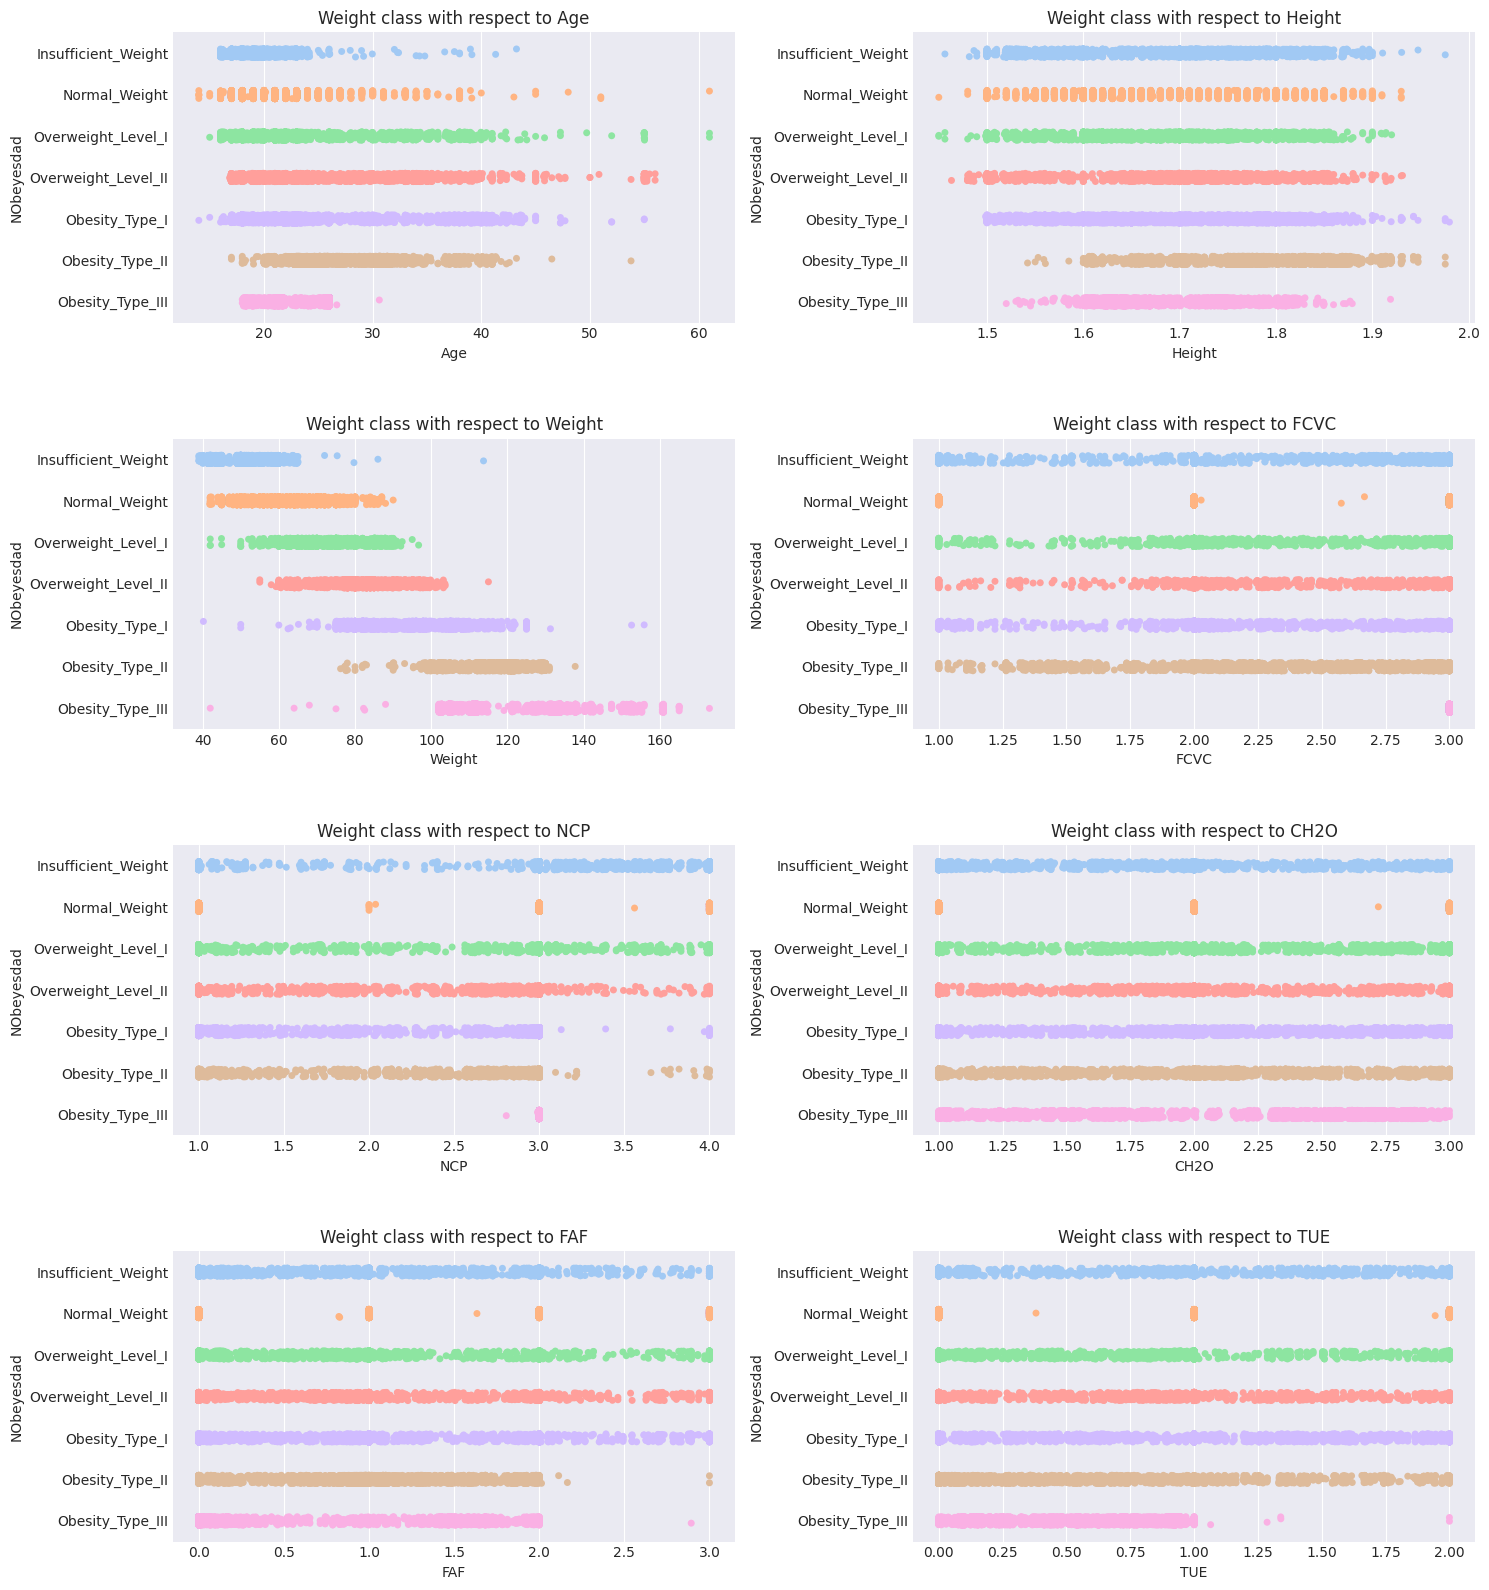

In [18]:
fig, axes = plt.subplots(4, 2, figsize=(15, 4*4))
# fig, axes = plt.subplots(so_hang, so_cot, figsize=(height, width)"inch")
axes = axes.flatten()
sns.stripplot(data=df, ax=axes[0], x='Age', y='NObeyesdad', palette='pastel', order=category_order)
sns.stripplot(data=df, ax=axes[1], x='Height', y='NObeyesdad', palette='pastel', order=category_order)
sns.stripplot(data=df, ax=axes[2], x='Weight', y='NObeyesdad', palette='pastel', order=category_order)
sns.stripplot(data=df, ax=axes[3], x='FCVC', y='NObeyesdad', palette='pastel', order=category_order)
sns.stripplot(data=df, ax=axes[4], x='NCP', y='NObeyesdad', palette='pastel', order=category_order)
sns.stripplot(data=df, ax=axes[5], x='CH2O', y='NObeyesdad', palette='pastel', order=category_order)
sns.stripplot(data=df, ax=axes[6], x='FAF', y='NObeyesdad', palette='pastel', order=category_order)
sns.stripplot(data=df, ax=axes[7], x='TUE', y='NObeyesdad', palette='pastel', order=category_order)
# Tieu de moi bieu do (Phan loai can nang (beo phi) theo ...)
axes[0].set_title('Weight class with respect to Age')
axes[1].set_title('Weight class with respect to Height')
axes[2].set_title('Weight class with respect to Weight')
axes[3].set_title('Weight class with respect to FCVC')
axes[4].set_title('Weight class with respect to NCP')
axes[5].set_title('Weight class with respect to CH2O')
axes[6].set_title('Weight class with respect to FAF')
axes[7].set_title('Weight class with respect to TUE')

plt.tight_layout()
plt.subplots_adjust(hspace=0.4) 
plt.show()

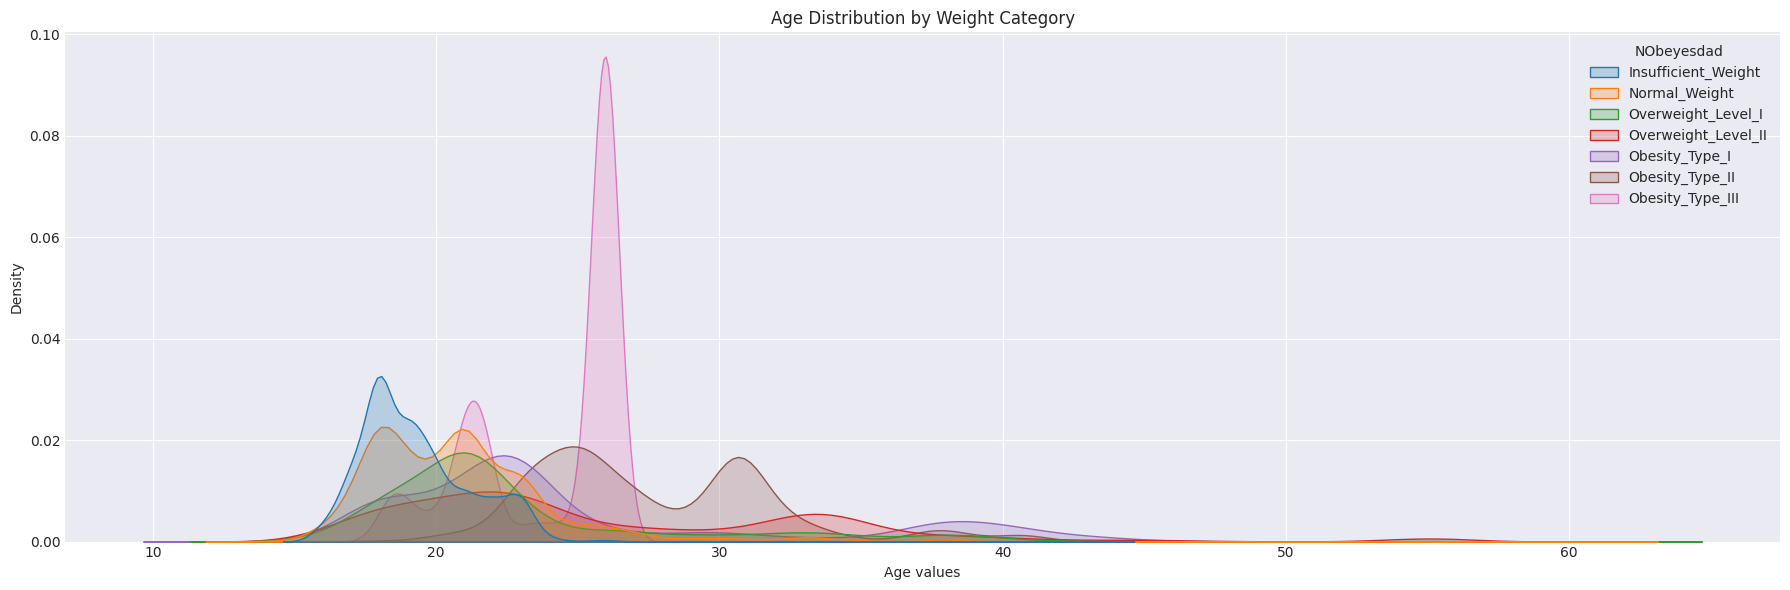

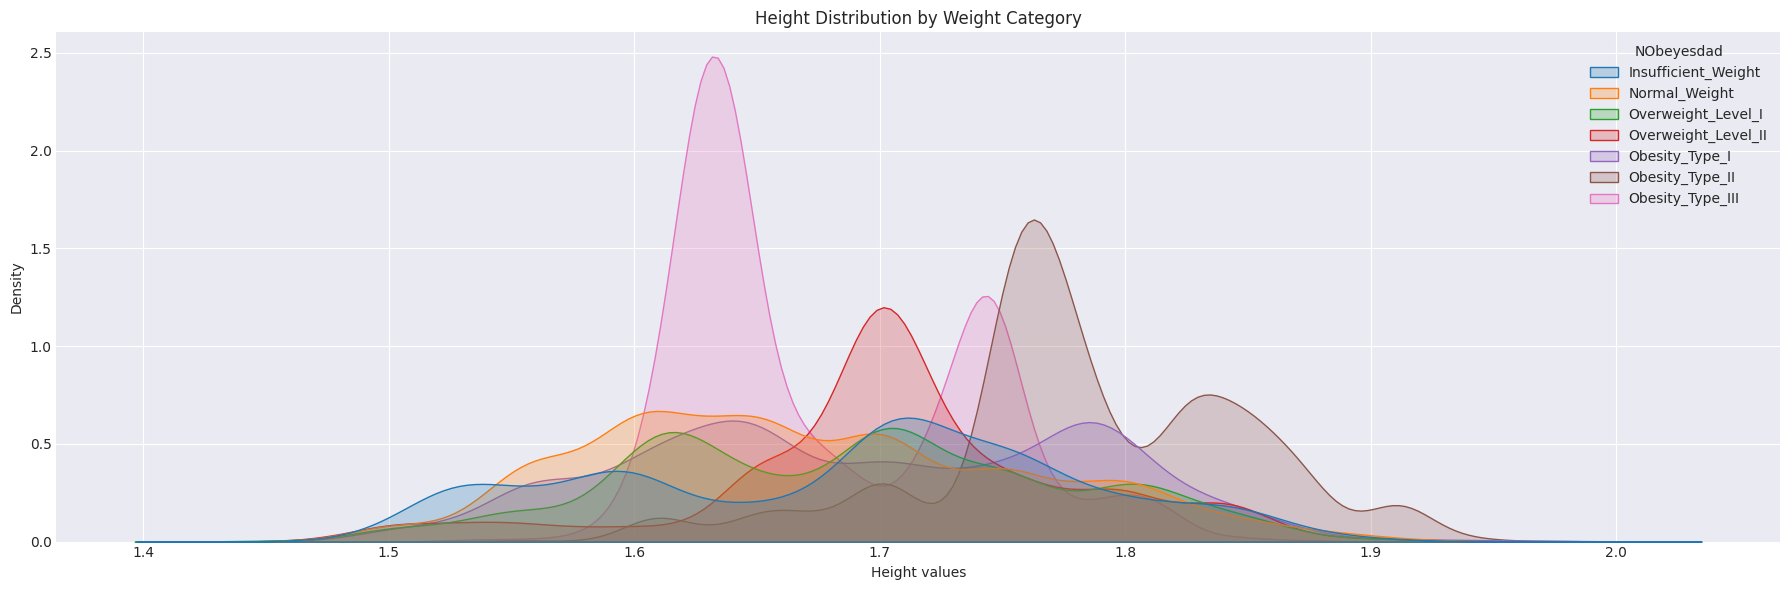

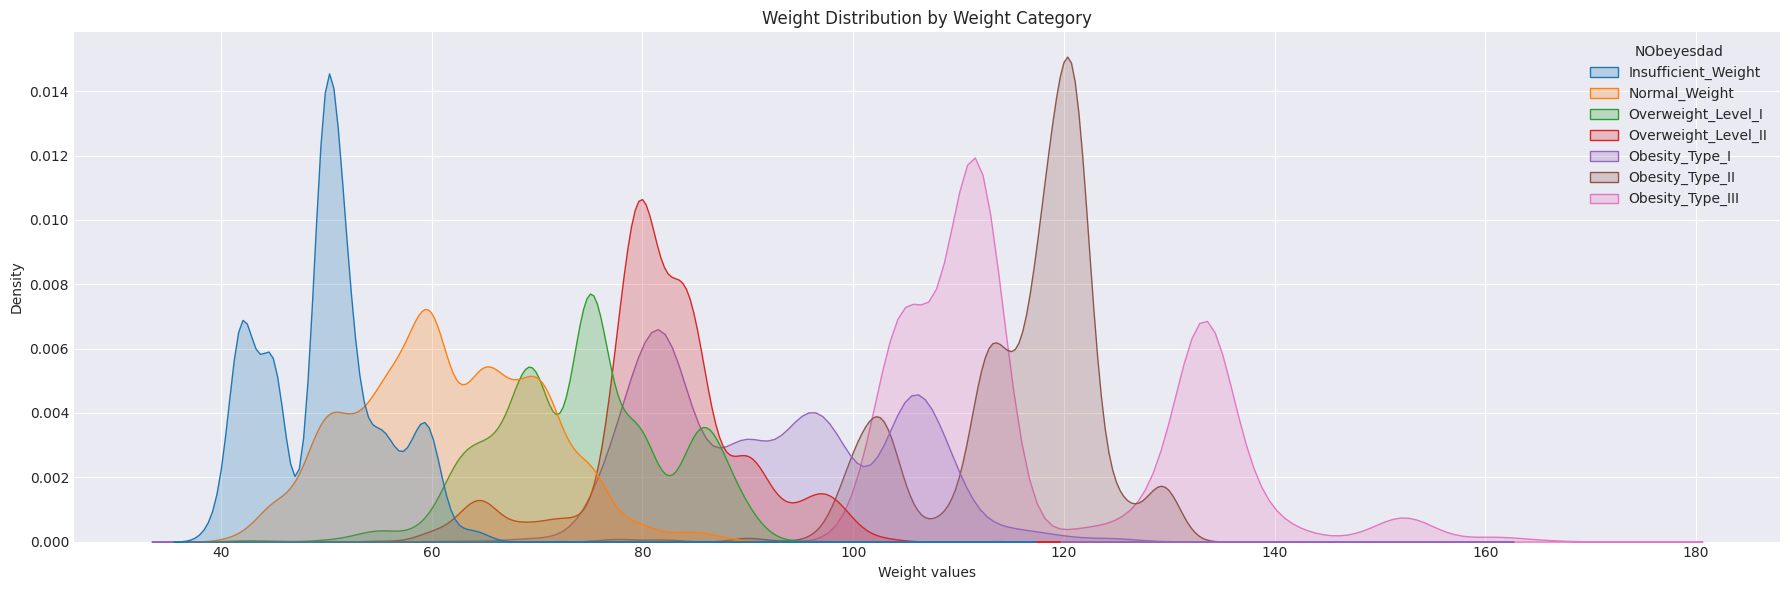

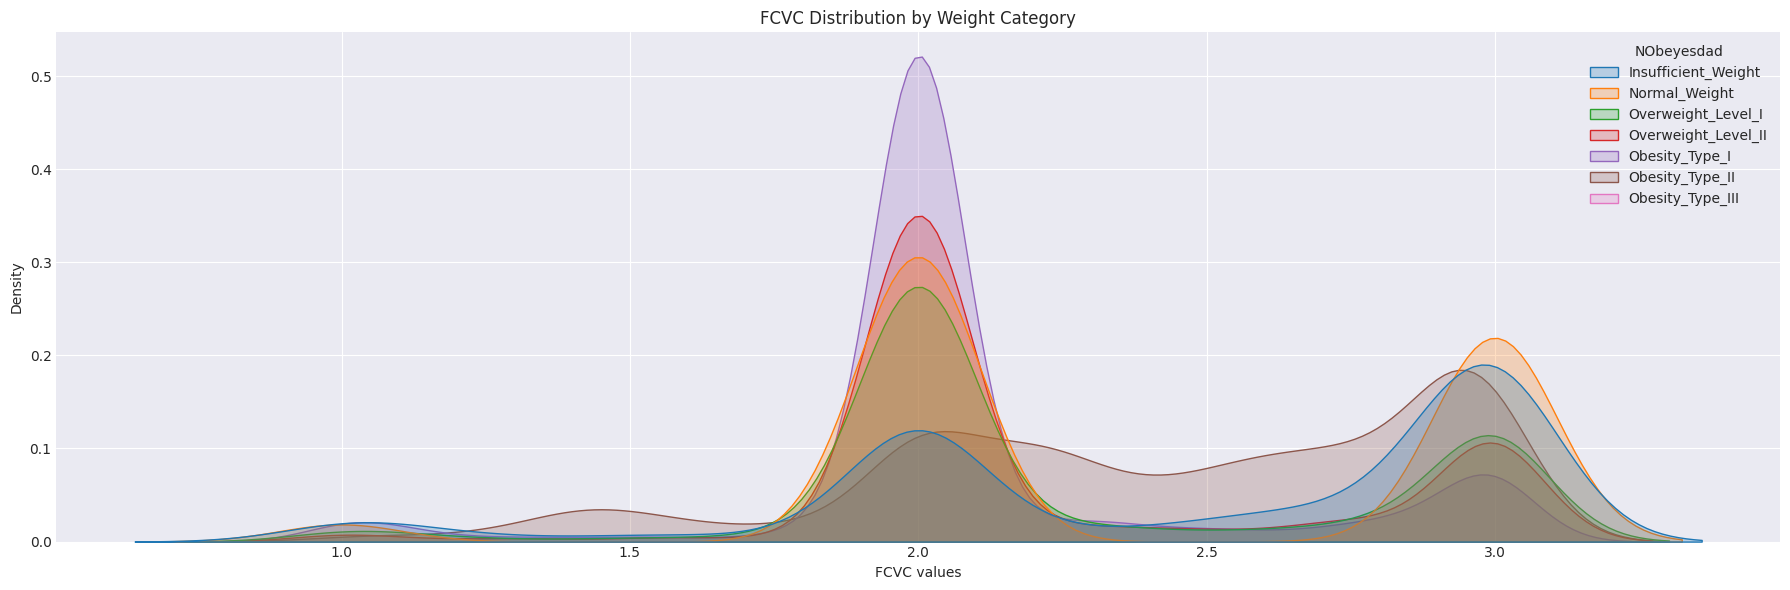

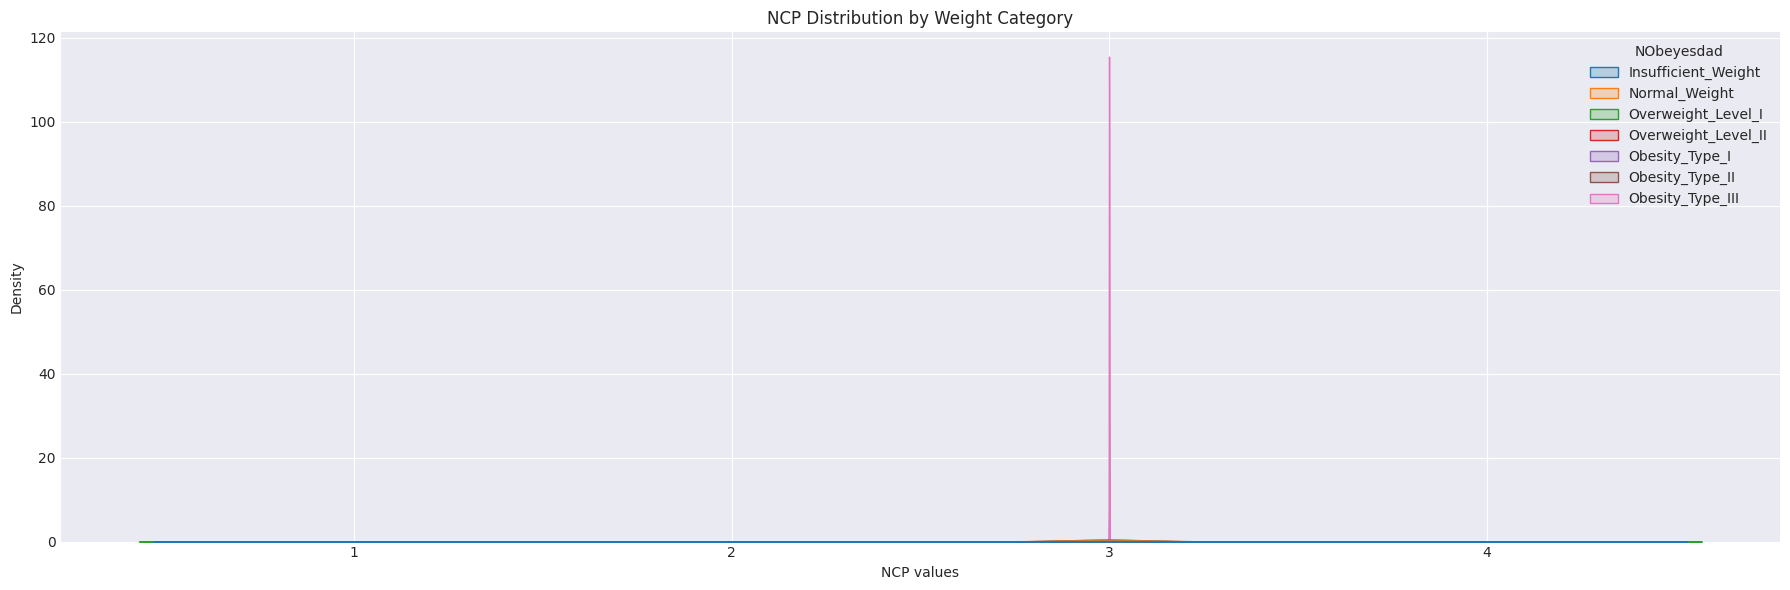

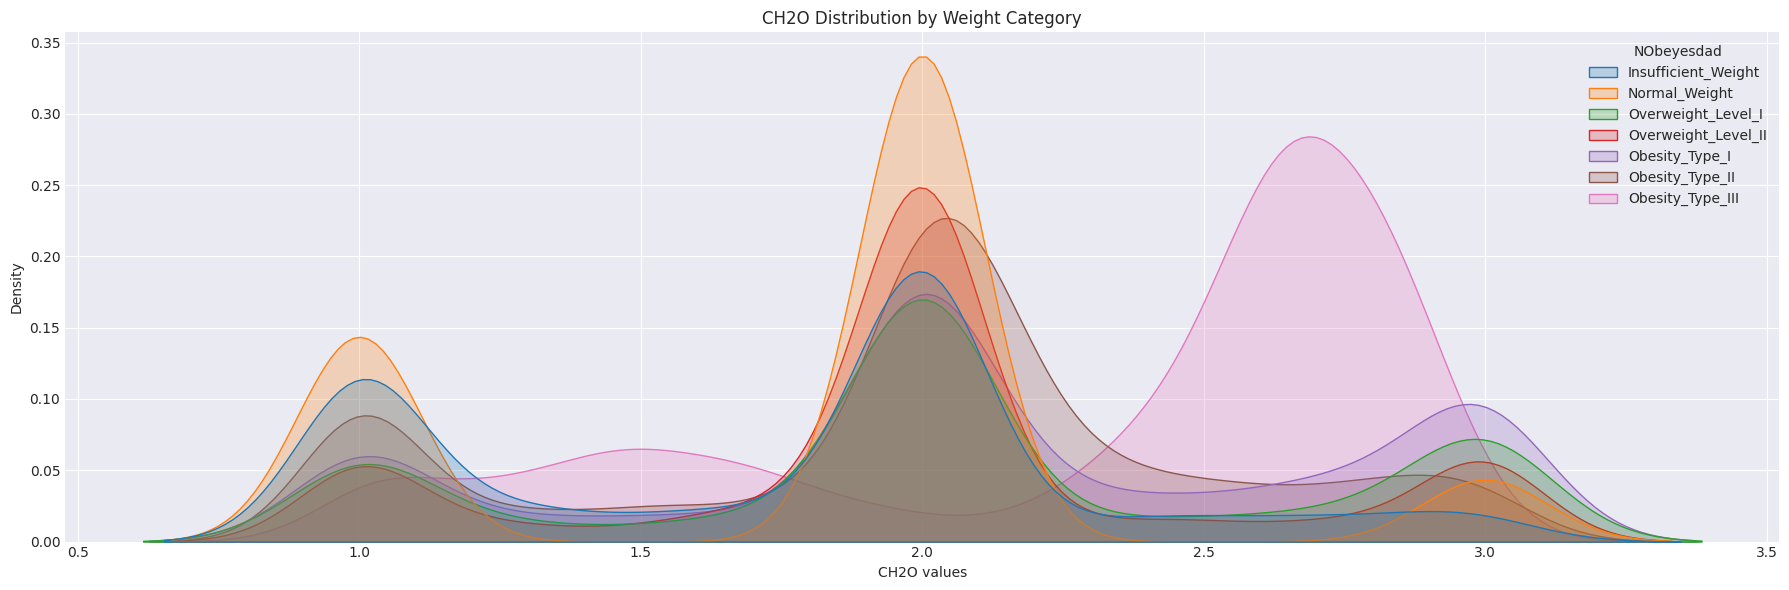

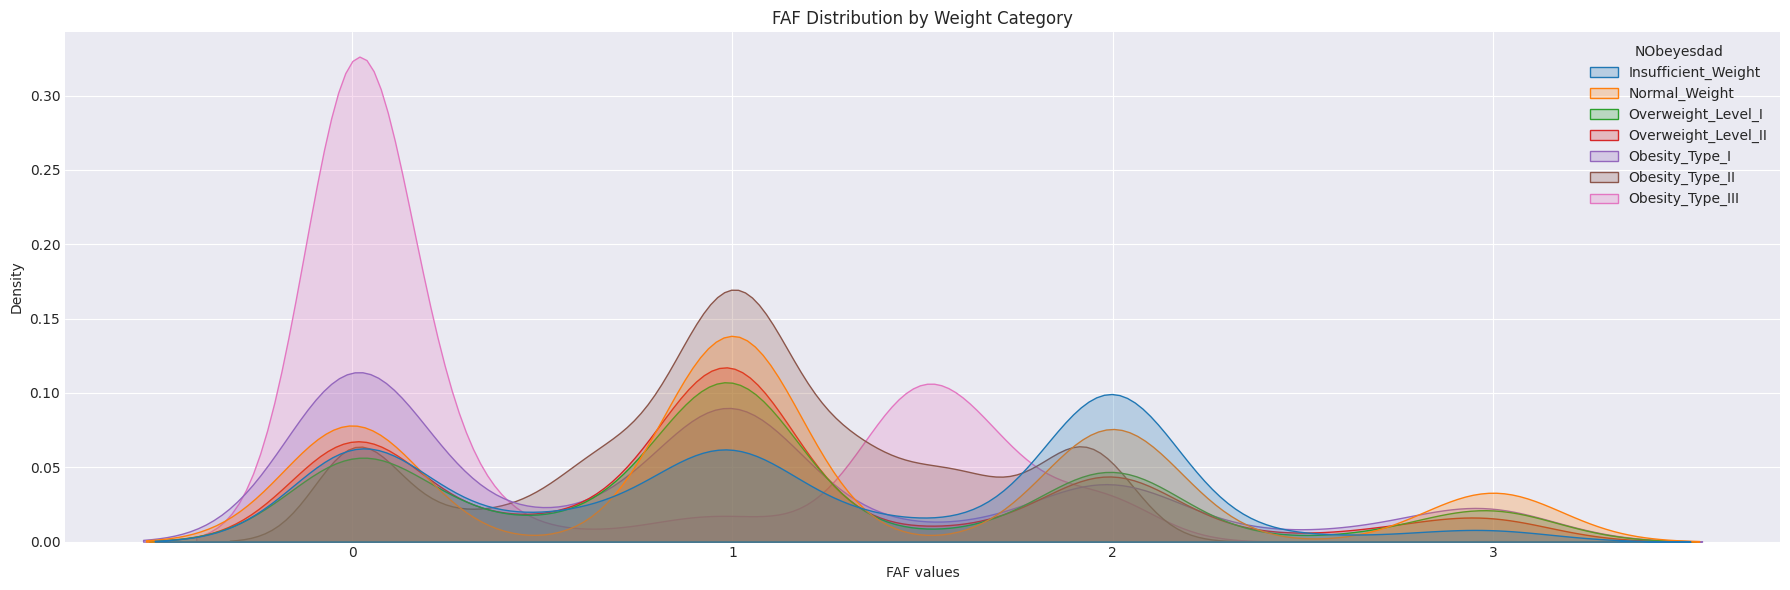

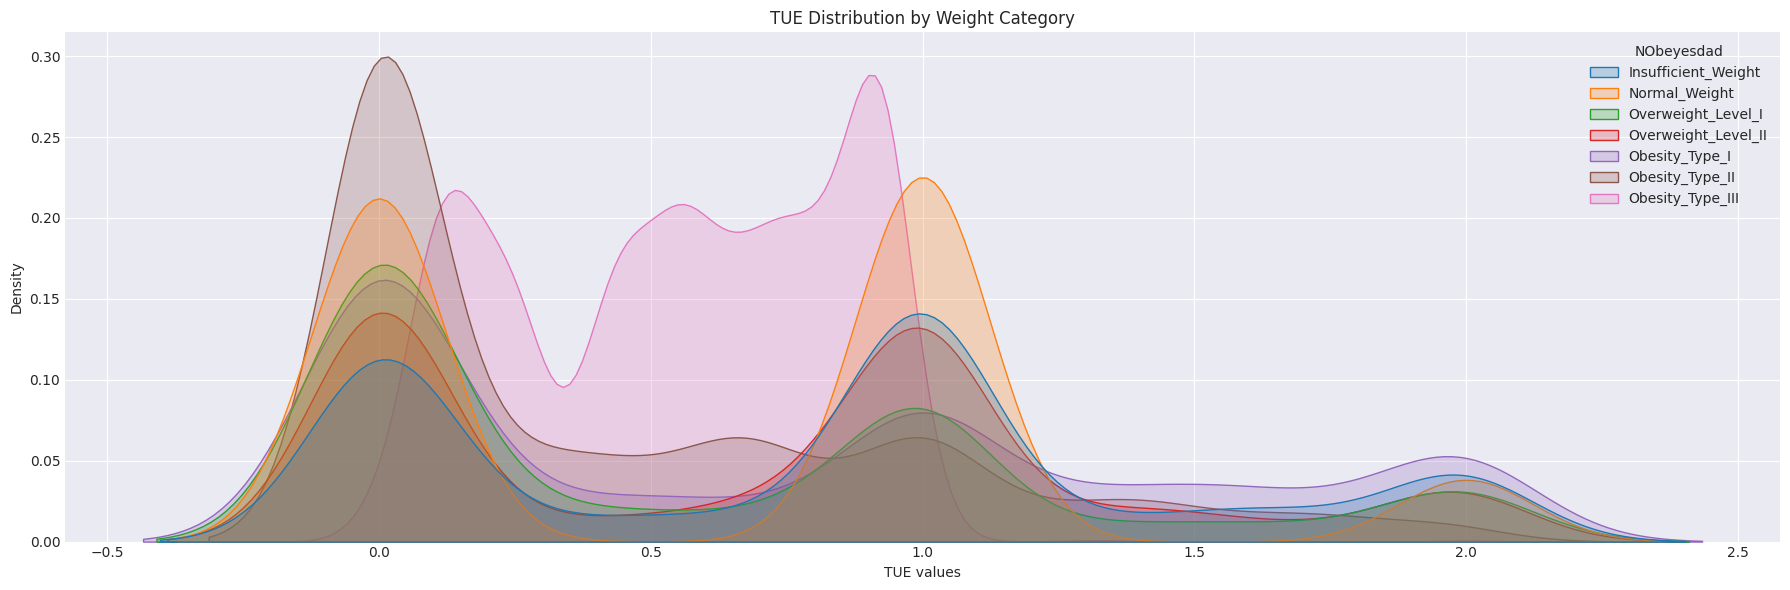

In [19]:
# Chuyen cot 'NObeyesdad' thanh cot phan loai theo thu tu da chi dinh
df['NObeyesdad'] = pd.Categorical(df['NObeyesdad'], categories=category_order, ordered=True)
# Anh xa cac ma phan loai thanh so nguyen
df['NObeyesdad_code'] = df['NObeyesdad'].cat.codes
# Sap xep bo du lieu dua theo 'NObeyesdad_code' (tuy chon, voi muc dich hien thi)
df_sorted = df.sort_values('NObeyesdad_code')
for col in numerical_cols:
    plt.figure(figsize=(18,6))
    # Bieu do KDE cho phan bo
    sns.kdeplot(data=df_sorted, x=col, hue='NObeyesdad', palette=sns.color_palette("tab10"), 
                fill=True)
    plt.xlabel(f'{col} values')
    plt.title(f'{col} Distribution by Weight Category')
    plt.tight_layout()
    plt.show()

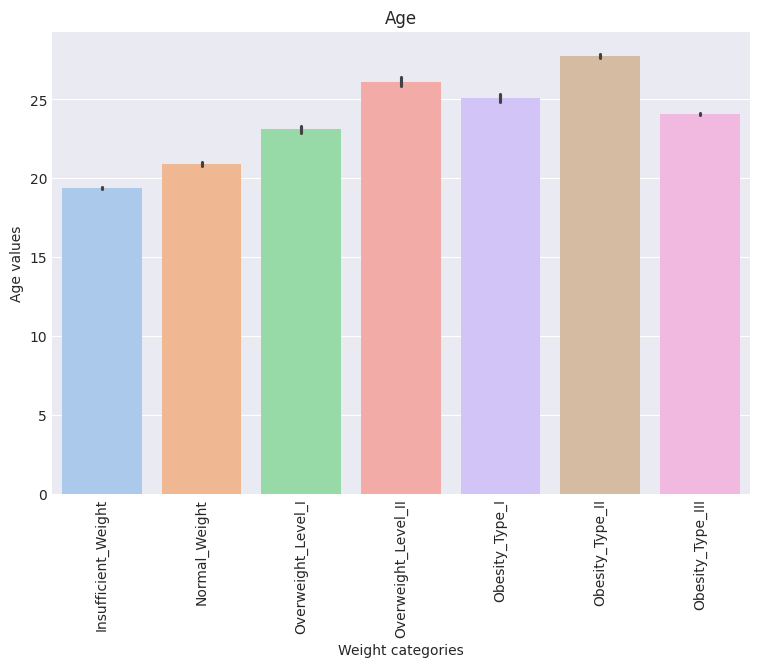

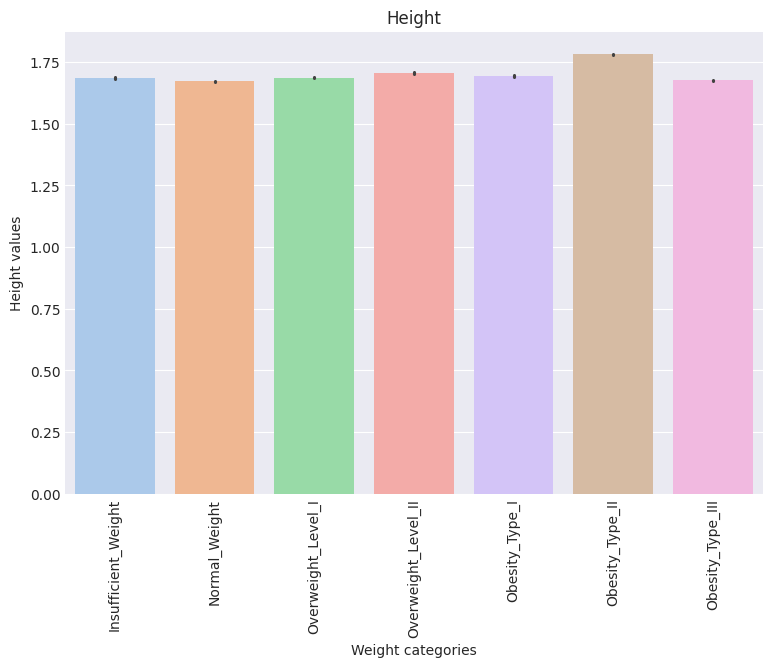

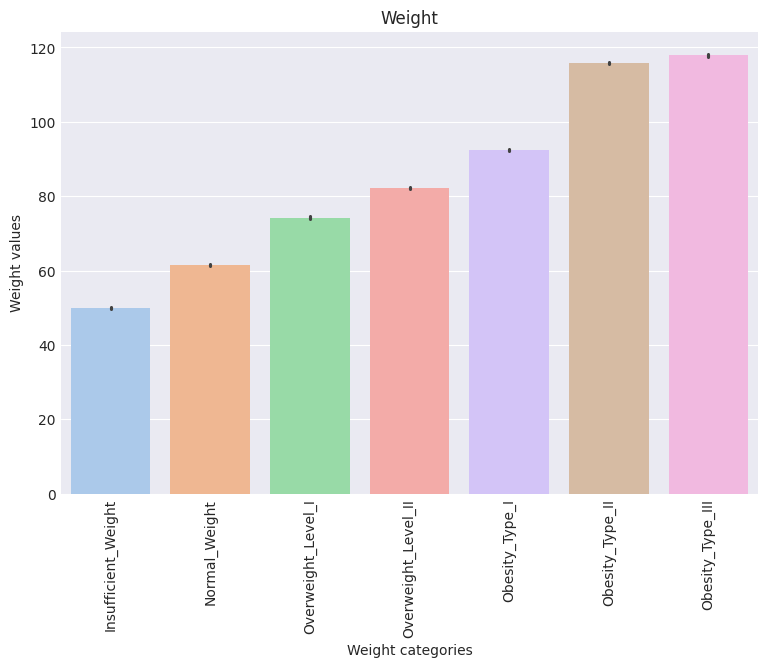

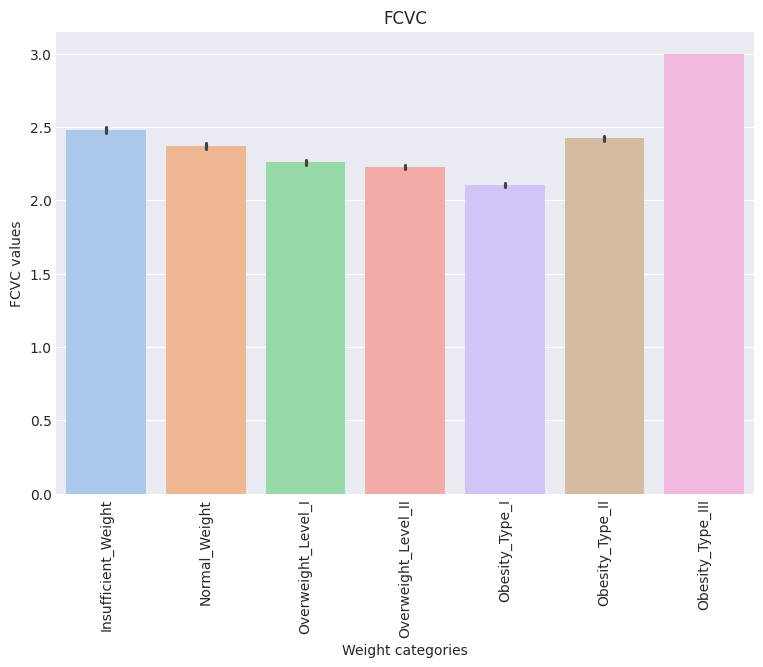

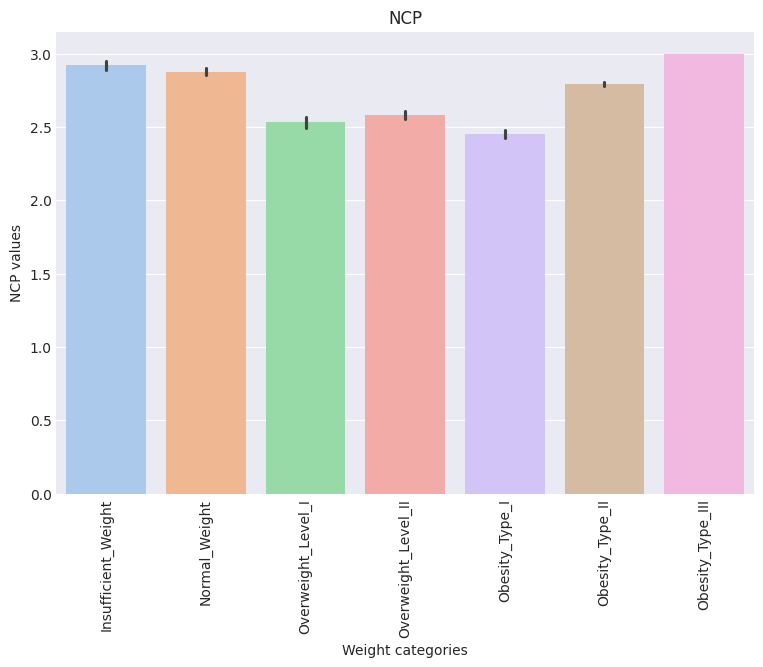

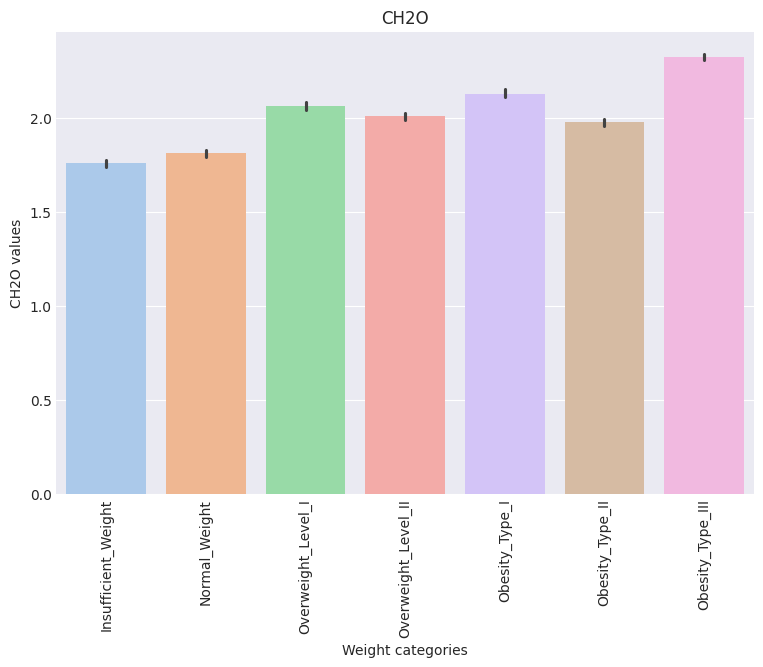

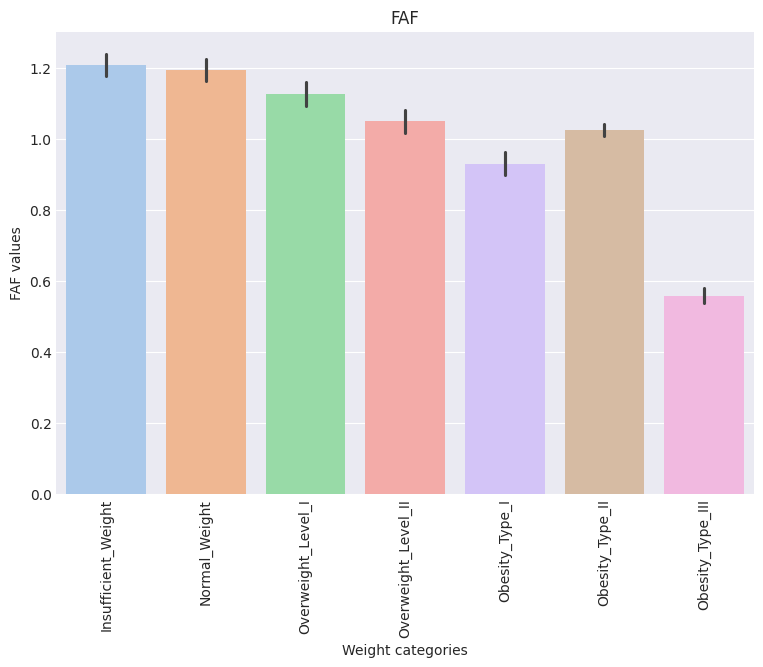

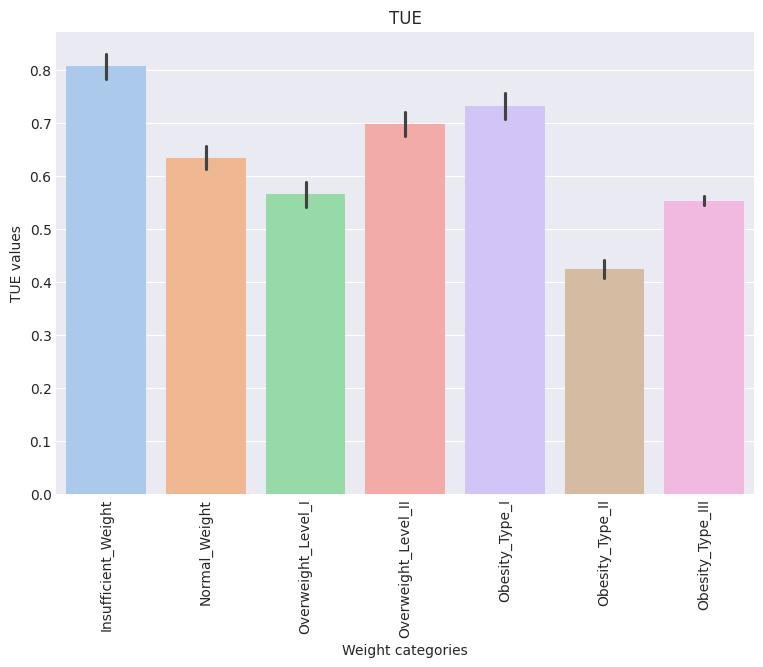

In [20]:
for col in numerical_cols:
    plt.figure(figsize=(9,6))
    sns.barplot(x='NObeyesdad', y=col, data=df, palette='pastel', order = category_order)
    plt.xticks(rotation=90)
    plt.xlabel('Weight categories')
    plt.ylabel(f'{col} values')
    plt.title(f'{col}')
plt.show()

### 3.6. Mối quan hệ giữa các đặc trưng phân loại và các lớp mục tiêu

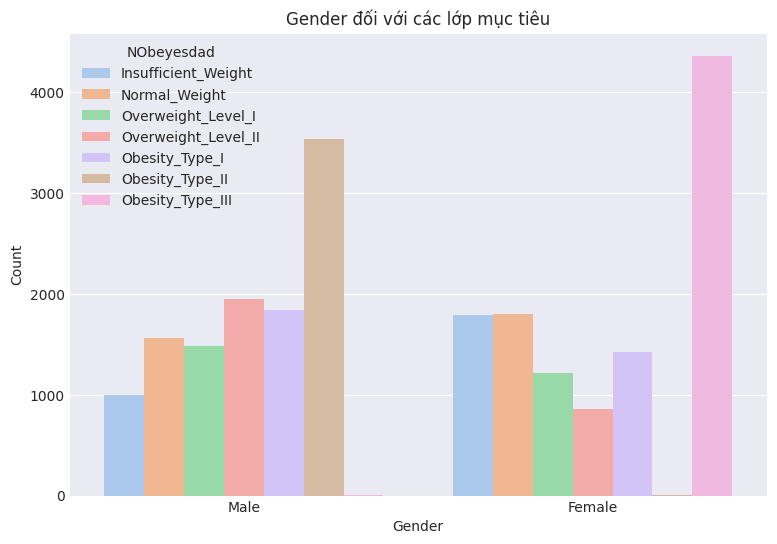

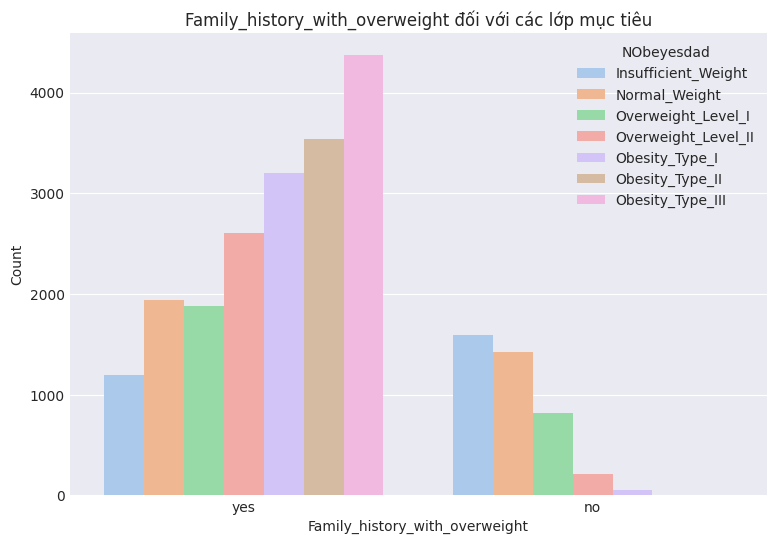

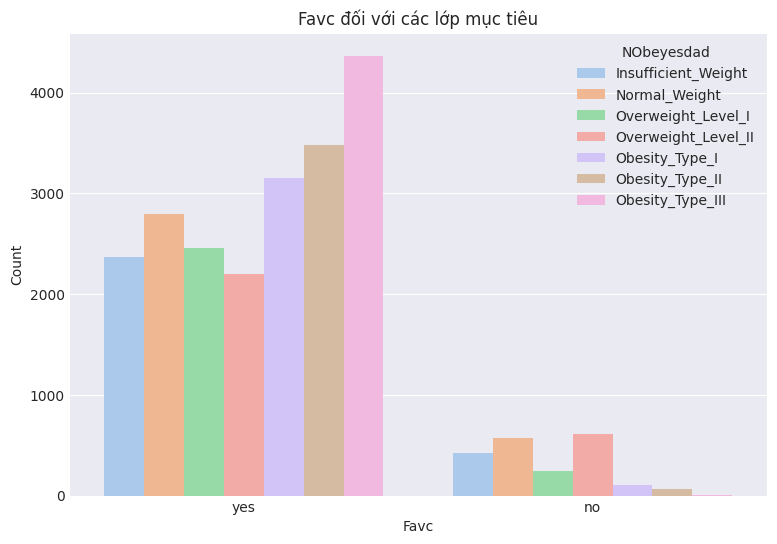

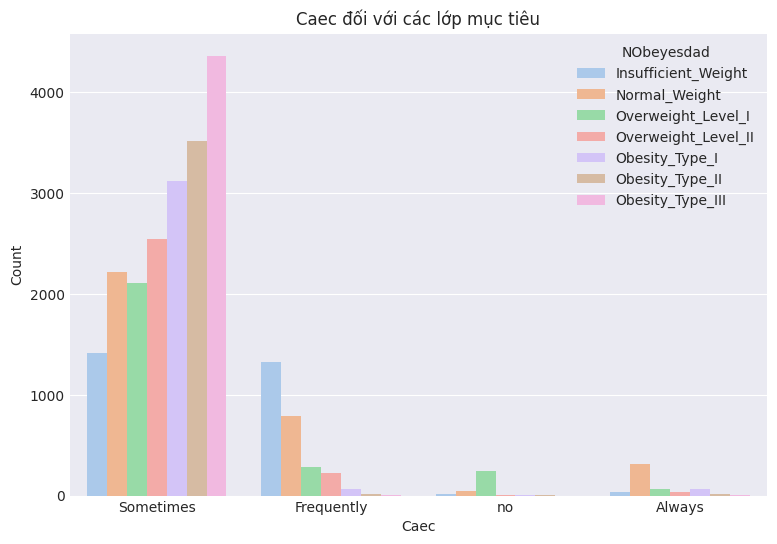

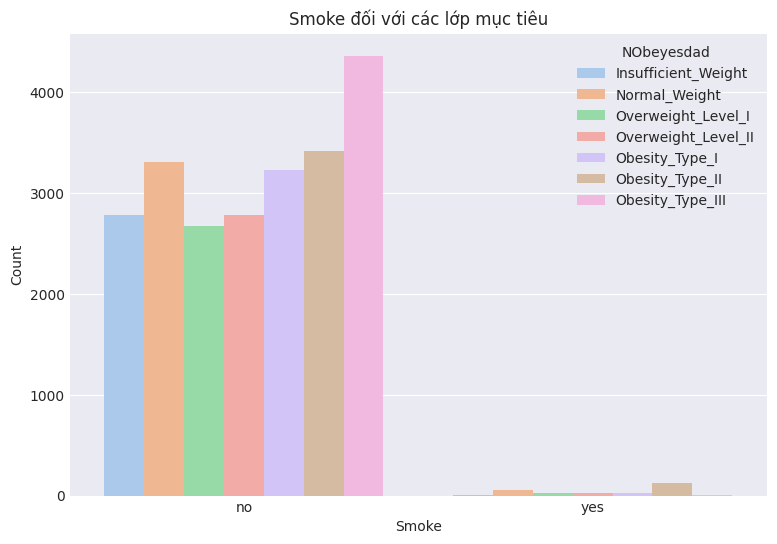

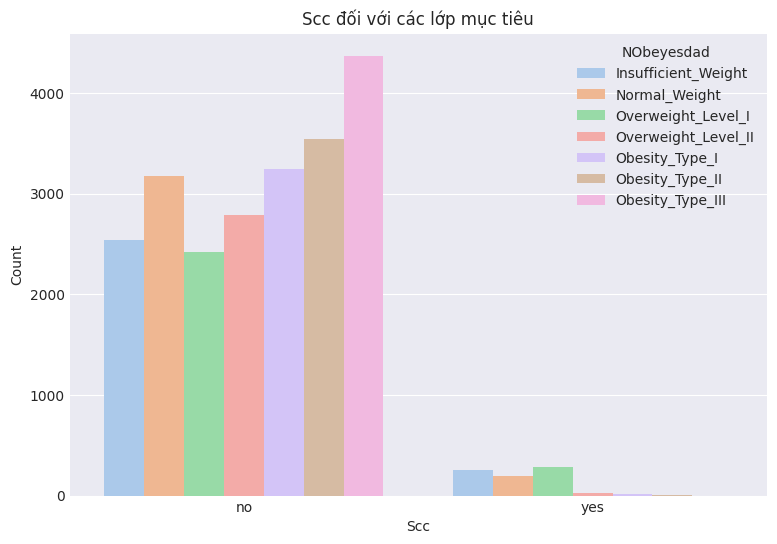

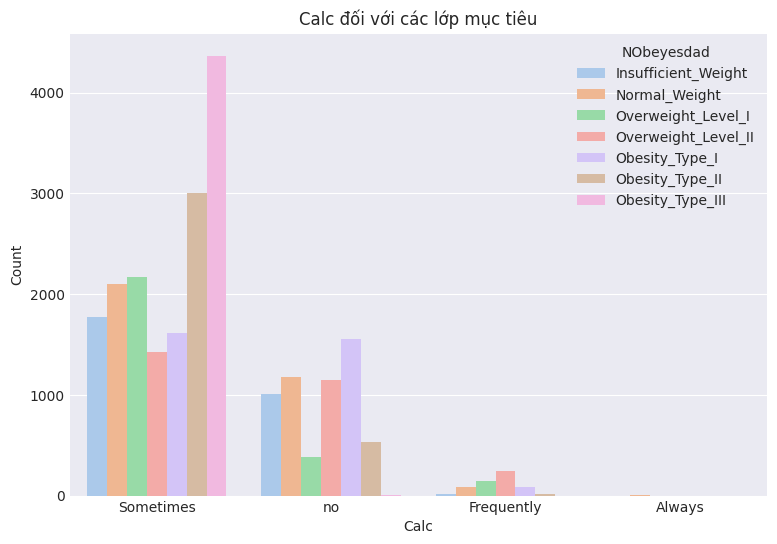

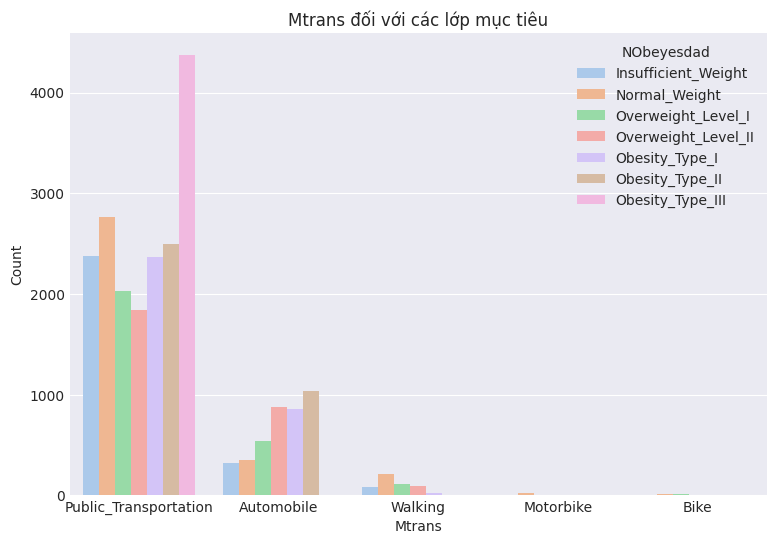

In [21]:
for col in categorical_cols:
    plt.figure(figsize=(9, 6))
    sns.countplot(data=df, x=col, hue='NObeyesdad', palette='pastel', hue_order=category_order)
    plt.title(f"{col.capitalize()} đối với các lớp mục tiêu")
    plt.xlabel(col.capitalize())
    plt.ylabel('Count')
    plt.legend(title='NObeyesdad')
    plt.show()

### 3.7. Mối quan hệ giữa các đặc trưng

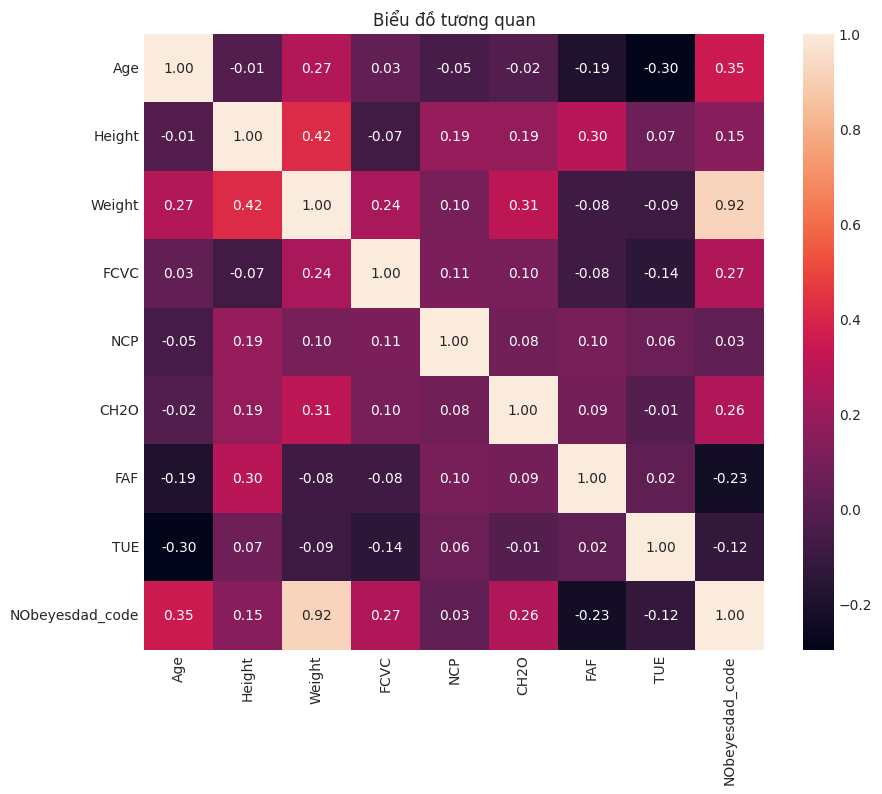

In [22]:
# Tinh toan ma tran tuong quan giua cac truong so
corr = df.corr(method='pearson', numeric_only=True)
# Ve bieu do heatmap cho ma tran tuong quan, hien thi gia tri tuong quan
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={"size": 10})
plt.title('Biểu đồ tương quan')
plt.show()

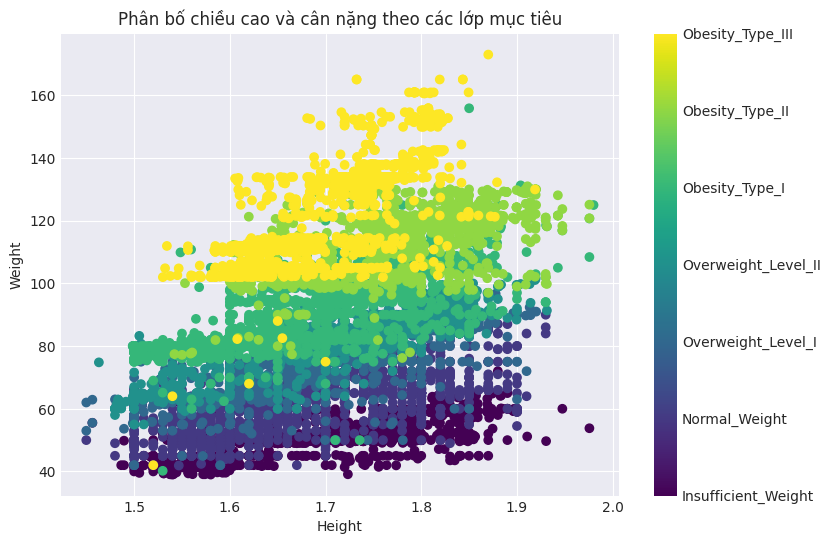

In [23]:
# Tao bieu do scatter
plt.figure(figsize=(9, 6))
scatter = plt.scatter(df_sorted['Height'], df_sorted['Weight'], c=df_sorted['NObeyesdad_code'], cmap='viridis')

# Thiet lap nhan va tieu de
plt.xlabel('Height')
plt.ylabel('Weight')
plt.title('Phân bố chiều cao và cân nặng theo các lớp mục tiêu')

# Tuy chinh thanh phan mau cho phu hop voi thu tu danh muc
cbar = plt.colorbar(scatter)
cbar.set_ticks(range(len(category_order)))
cbar.set_ticklabels(category_order)
plt.show()


## 4. Tiền xử lý dữ liệu

In [24]:
df = pd.read_csv('data/train.csv')
# Xoa cot id
df.drop(columns='id', inplace=True)
df_org = pd.read_csv('data/ObesityDataSet.csv')
# Ghep 2 bang du lieu
df = pd.concat([df, df_org], ignore_index=True)

In [25]:
numerical_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in df.columns if df[cname].dtype == "object" and cname != 'NObeyesdad']
print('Numerical Columns (Trường số liệu): ', numerical_cols)
print('Categorical Columns (Trường thể loại): ', categorical_cols)

Numerical Columns (Trường số liệu):  ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
Categorical Columns (Trường thể loại):  ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']


In [26]:
# Tach cac dac trung va nhan muc tieu
y = df['NObeyesdad']
X = df.drop(columns='NObeyesdad')
# Ma hoa cac nhan (lop) muc tieu
mapping = {'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2, 'Overweight_Level_II': 3, 'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6}
inverse_mapping = {v: k for k, v in mapping.items()}
y = y.map(mapping)
print(y)


0        3
1        1
2        0
3        6
4        3
        ..
22864    6
22865    6
22866    6
22867    6
22868    6
Name: NObeyesdad, Length: 22869, dtype: int64


In [27]:
# Chuyen doi phan bo cua Age ve phan bo binh thuong
df['Age'], _  = boxcox(df['Age'])

Text(0, 0.5, 'Tần suất')

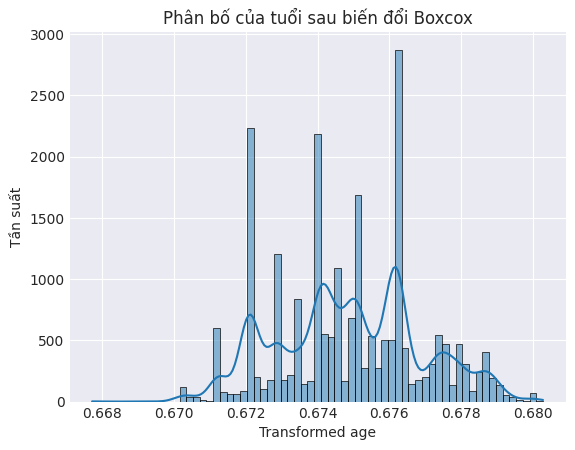

In [28]:
sns.histplot(data=df, x='Age', palette='pastel', kde=True)
plt.title('Phân bố của tuổi sau biến đổi Boxcox')
plt.xlabel('Transformed age')
plt.ylabel('Tần suất')

In [29]:
# Roi rac hoa cac gia tri FCVC, NCP, CH2O, FAF, TUE
df['FCVC'] = pd.cut(df['FCVC'],
                              bins=[0.5,1.5,2.5,3.5],
                              labels=[1,2,3]).astype('float64')
df['NCP'] = pd.cut(df['NCP'],
                              bins=[0.5,1.5,2.5,3.5,4.5],
                              labels=[1,2,3,4]).astype('float64')
df['CH2O'] = pd.cut(df['CH2O'],
                              bins=[0.5,1.5,2.5,3.5],
                              labels=[1,2,3]).astype('float64')
df['FAF'] = pd.cut(df['FAF'],
                              bins=[-0.5,0.5,1.5,2.5,3.5],
                              labels=[0,1,2,3]).astype('float64')
df['TUE'] = pd.cut(df['TUE'],
                              bins=[-0.5,0.5,1.5,2.5],
                              labels=[0,1,2]).astype('float64')

In [30]:
# Chia thanh tap huan luyen va tap kiem tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=RANDOM_STATE)

In [31]:
# In kich thuoc cac tap huan luyen va tap kiem tra
print(X_train.shape)
print(X_test.shape)

(18295, 16)
(4574, 16)


In [32]:
# Kiem tra su phan bo cua cac lop muc tieu trong tap huan luyen va tap kiem tra
print(y_train.value_counts() / y_train.shape[0])
print(y_test.value_counts() / y_test.shape[0])

NObeyesdad
6    0.191090
5    0.155015
1    0.147308
4    0.142607
3    0.122930
0    0.122219
2    0.118830
Name: count, dtype: float64
NObeyesdad
6    0.191080
5    0.155007
1    0.147355
4    0.142545
3    0.123087
0    0.122213
2    0.118714
Name: count, dtype: float64


In [33]:
# Bộ mã hóa cột này chuẩn bị dữ liệu bằng cách mã hóa dữ liệu phân loại, chuẩn hóa dữ liệu số, và kết hợp chúng thành một DataFrame đầu ra có thể sử dụng được cho mô hình học máy.
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='if_binary')
oe = OrdinalEncoder(categories = [['no', 'Sometimes', 'Frequently', 'Always']] * 2)
scaler = StandardScaler()
col_trans = make_column_transformer(
    (ohe, ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'MTRANS']),
    (oe, ['CAEC', 'CALC']),
    (scaler, ['Age', 'Height', 'Weight']),
    remainder='passthrough',
    n_jobs=-1
)
col_trans.set_output(transform='pandas')

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['Gender', 'family_history_with_overweight',
                                  'FAVC', 'SMOKE', 'SCC', 'MTRANS']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[['no', 'Sometimes',
                                                             'Frequently',
                                                             'Always'],
                                                            ['no', 'Sometimes',
                                                             'Frequently',
                                                             'Always']]),
                                 ['CAEC', 'CALC']),
                                ('standardscaler', StandardScaler(),
                                 ['Age', 'Height', 'Weight'])])

In [34]:
# Tien xu ly tap huan luyen va tap kiem tra
X_train = col_trans.fit_transform(X_train)
X_test = col_trans.transform(X_test)

# Luu ColumnTransformer vao file
filename = os.path.join('checkpoint/', 'preprocessing.joblib')
joblib.dump(col_trans,filename)

['checkpoint/preprocessing.joblib']

In [35]:
# Hien thi bang X_train
X_train

,onehotencoder__Gender_Male,onehotencoder__family_history_with_overweight_yes,onehotencoder__FAVC_yes,onehotencoder__SMOKE_yes,onehotencoder__SCC_yes,onehotencoder__MTRANS_Automobile,onehotencoder__MTRANS_Bike,onehotencoder__MTRANS_Motorbike,onehotencoder__MTRANS_Public_Transportation,onehotencoder__MTRANS_Walking,ordinalencoder__CAEC,ordinalencoder__CALC,standardscaler__Age,standardscaler__Height,standardscaler__Weight,remainder__FCVC,remainder__NCP,remainder__CH2O,remainder__FAF,remainder__TUE
19926,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,-0.658570,0.469692,1.556339,3.000000,3.000000,2.444125,0.110887,0.778632
15522,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.598548,0.228749,-0.179638,2.000000,1.000000,2.000000,1.000000,0.000000
15970,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,-0.658357,0.404533,1.898993,3.000000,3.000000,2.387991,1.926280,0.923005
18897,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.645873,1.800756,0.373543,2.000000,3.000000,3.000000,1.191020,1.040713
11157,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,-1.026216,0.001359,-1.431440,2.000000,4.000000,1.000000,2.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19579,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.773773,-1.913155,-0.942958,2.048216,1.000000,1.274718,1.612741,1.000000
21302,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,-0.605051,0.637802,-1.291103,2.000000,3.891994,1.863930,2.870127,2.000000
666,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.373658,-0.851924,0.916129,3.000000,3.000000,2.709140,0.000000,0.200379
4435,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.307216,1.687390,1.273599,2.175276,2.562895,1.000000,0.903369,0.000000


In [36]:
#Kiem tra if mean = 0 and std = 1 or not
print(X_train['standardscaler__Age'].mean())
print(X_train['standardscaler__Age'].std())

-8.835663972966536e-17
1.0000273309919836


## 5. Thử nghiệm các thuật toán

In [37]:
# Tao DataFrame de luu tru hieu suat cua mo hinh
df_results = pd.DataFrame()

In [38]:
# Ham dieu chinh sieu tham so
def hyper_search(model, model_name, param_grid, X_train, y_train, cv=5, n_iter=20, scoring='accuracy', random_state=RANDOM_STATE):
    global df_results
    # Dieu chinh sieu tham so
    rs = RandomizedSearchCV(model, param_grid, n_iter=n_iter, n_jobs=-1, cv=StratifiedKFold(n_splits=cv), scoring=scoring, return_train_score=True, random_state=random_state)
    rs.fit(X_train, y_train)
    best_model = rs.best_estimator_
    
    # them bao cao ve sieu tham so tot nhat cua mo hinh vao DataFrame
    result = pd.DataFrame(rs.cv_results_)
    result.sort_values('rank_test_score', inplace=True)
    result = result[['params', 'mean_fit_time', 'mean_score_time', 'mean_test_score', 'mean_train_score']]
    display(result)
    best_hyper = result.loc[result['params']==rs.best_params_]
    best_hyper['model_name'] = model_name
    df_results = pd.concat([df_results, best_hyper], ignore_index=True)
    
    # Luu mo hinh
    filename = os.path.join('checkpoint/', f'{model_name}.joblib')
    joblib.dump(best_model,filename)
    
#     # Luu ket qua bao cao
#     df_results.to_csv('report_result.csv')
    
    return best_model

### 5.1. Thuật toán kNN

In [39]:
param_grid = [{
        'n_neighbors': [2, 5, 8, 10, 20],
        'p': [1, 2],
}]
knn = hyper_search(KNeighborsClassifier(), 'knn', param_grid, X_train, y_train)

,params,mean_fit_time,mean_score_time,mean_test_score,mean_train_score
8,"{'p': 1, 'n_neighbors': 20}",0.008595,1.546251,0.829735,0.848401
6,"{'p': 1, 'n_neighbors': 10}",0.009443,1.487224,0.828040,0.862708
4,"{'p': 1, 'n_neighbors': 8}",0.009354,1.313626,0.827221,0.866029
2,"{'p': 1, 'n_neighbors': 5}",0.008610,1.329428,0.819350,0.877316
7,"{'p': 2, 'n_neighbors': 10}",0.005003,0.736560,0.802514,0.839000
5,"{'p': 2, 'n_neighbors': 8}",0.009536,0.650923,0.799836,0.846570
9,"{'p': 2, 'n_neighbors': 20}",0.009224,0.712065,0.796775,0.819732
3,"{'p': 2, 'n_neighbors': 5}",0.008914,0.596266,0.795627,0.861260
0,"{'p': 1, 'n_neighbors': 2}",0.008313,1.361760,0.778956,0.896556
1,"{'p': 2, 'n_neighbors': 2}",0.007868,0.592823,0.764198,0.889136


### 5.2. Thuật toán Logistic Regression

In [40]:
param_grid = [{
        'C': [1e-1, 1, 10, 100, 1000],
        'penalty': ['l2']
    },
{
    'penalty': [None]
}]
logreg = hyper_search(LogisticRegression(max_iter=10000, random_state=RANDOM_STATE), 'logistic_regression', param_grid, X_train, y_train)

,params,mean_fit_time,mean_score_time,mean_test_score,mean_train_score
5,{'penalty': None},2.194579,0.001171,0.870456,0.872451
3,"{'penalty': 'l2', 'C': 100}",2.565838,0.002527,0.869964,0.872424
2,"{'penalty': 'l2', 'C': 10}",3.817806,0.003926,0.869855,0.872137
4,"{'penalty': 'l2', 'C': 1000}",2.162033,0.001539,0.869800,0.872383
1,"{'penalty': 'l2', 'C': 1}",3.287612,0.001221,0.865100,0.867559
0,"{'penalty': 'l2', 'C': 0.1}",2.039204,0.005136,0.835420,0.837182


### 5.3. Cây quyết định

In [41]:
param_grid = [{
        'max_depth': [5, 10, 15, 20],
        'min_samples_leaf': [5, 10, 20, 30, 50],
        'criterion': ['gini', 'entropy']
    }]
decision_tree = hyper_search(DecisionTreeClassifier(random_state=RANDOM_STATE), 'decision_tree', param_grid, X_train, y_train)

,params,mean_fit_time,mean_score_time,mean_test_score,mean_train_score
3,"{'min_samples_leaf': 10, 'max_depth': 10, 'cri...",0.098804,0.003331,0.883083,0.907092
7,"{'min_samples_leaf': 20, 'max_depth': 10, 'cri...",0.098259,0.001045,0.882263,0.897622
10,"{'min_samples_leaf': 5, 'max_depth': 10, 'crit...",0.111772,0.003299,0.881990,0.914430
19,"{'min_samples_leaf': 30, 'max_depth': 15, 'cri...",0.069536,0.003286,0.881880,0.890940
6,"{'min_samples_leaf': 20, 'max_depth': 20, 'cri...",0.105453,0.001333,0.881716,0.898634
16,"{'min_samples_leaf': 20, 'max_depth': 20, 'cri...",0.092757,0.004795,0.881607,0.897390
5,"{'min_samples_leaf': 20, 'max_depth': 15, 'cri...",0.084135,0.002323,0.881607,0.897390
12,"{'min_samples_leaf': 30, 'max_depth': 15, 'cri...",0.091520,0.001642,0.881388,0.891213
15,"{'min_samples_leaf': 30, 'max_depth': 10, 'cri...",0.081401,0.002824,0.881060,0.890899
9,"{'min_samples_leaf': 10, 'max_depth': 10, 'cri...",0.088166,0.004956,0.880186,0.905985


### 5.4. Rừng ngẫu nhiên

In [42]:
param_grid = [{
        'n_estimators': [100, 300, 500, 1000, 2000],
        'max_depth': [10, 20, 30],
        'min_samples_leaf': [10, 20, 30],
        'criterion': ['gini', 'entropy']
    }]
random_forest = hyper_search(RandomForestClassifier(random_state=RANDOM_STATE), 'random_forest', param_grid, X_train, y_train)

,params,mean_fit_time,mean_score_time,mean_test_score,mean_train_score
19,"{'n_estimators': 500, 'min_samples_leaf': 10, ...",13.941316,0.282363,0.896529,0.922165
16,"{'n_estimators': 1000, 'min_samples_leaf': 10,...",21.550859,0.713780,0.895600,0.921591
18,"{'n_estimators': 2000, 'min_samples_leaf': 10,...",39.018602,0.586550,0.891719,0.914061
15,"{'n_estimators': 2000, 'min_samples_leaf': 10,...",37.939763,1.060639,0.890353,0.911684
6,"{'n_estimators': 2000, 'min_samples_leaf': 20,...",38.782757,1.021254,0.888166,0.906395
10,"{'n_estimators': 300, 'min_samples_leaf': 20, ...",8.105824,0.164955,0.888002,0.906600
1,"{'n_estimators': 500, 'min_samples_leaf': 20, ...",8.860299,0.255684,0.887948,0.906259
11,"{'n_estimators': 100, 'min_samples_leaf': 20, ...",1.950616,0.055190,0.886472,0.904427
7,"{'n_estimators': 100, 'min_samples_leaf': 20, ...",2.637581,0.057977,0.886253,0.905029
4,"{'n_estimators': 100, 'min_samples_leaf': 10, ...",1.578802,0.047335,0.885816,0.908705


### 5.5. XGBoost (Giải thuật được base trên gradient boosting)

**XGBoost (Extreme Gradient Boosting)** là một thuật toán học máy mạnh mẽ được xây dựng dựa trên phương pháp gradient boosting, với trọng tâm là tối ưu hóa hiệu suất và tốc độ tính toán. XGBoost nổi bật nhờ khả năng xử lý các bài toán hồi quy và phân loại thông qua việc xây dựng nhiều mô hình cây quyết định (decision trees) nhỏ, kết hợp chúng để tạo ra các dự đoán chính xác hơn. Thuật toán này được tối ưu hóa để tính toán song song, sử dụng bộ nhớ hiệu quả, và hỗ trợ tốt việc xử lý các giá trị thiếu trong dữ liệu. XGBoost còn cung cấp các phương pháp regularization (điều chuẩn) giúp giảm thiểu hiện tượng overfitting (quá khớp), làm cho nó trở thành lựa chọn lý tưởng trong các bài toán dữ liệu lớn hoặc các cuộc thi học máy nhờ vào khả năng tùy chỉnh linh hoạt và hiệu suất cao.

In [43]:
# Extreme Gradient Boosting
param_grid = [{
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [10, 15, 20]
    }]
xg_boost = hyper_search(XGBClassifier(random_state=RANDOM_STATE), 'xg_boost', param_grid, X_train, y_train)

,params,mean_fit_time,mean_score_time,mean_test_score,mean_train_score
7,"{'n_estimators': 500, 'max_depth': 15}",15.425583,0.737314,0.905712,1.000000
6,"{'n_estimators': 300, 'max_depth': 15}",10.218815,0.519670,0.905548,1.000000
5,"{'n_estimators': 200, 'max_depth': 15}",7.463377,0.317700,0.905056,1.000000
0,"{'n_estimators': 100, 'max_depth': 10}",4.716582,0.143860,0.904947,0.999891
4,"{'n_estimators': 100, 'max_depth': 15}",4.736887,0.180979,0.904837,1.000000
10,"{'n_estimators': 300, 'max_depth': 20}",9.618519,0.445614,0.904837,1.000000
11,"{'n_estimators': 500, 'max_depth': 20}",12.319907,0.571219,0.904837,1.000000
2,"{'n_estimators': 300, 'max_depth': 10}",10.092451,0.426622,0.904072,1.000000
9,"{'n_estimators': 200, 'max_depth': 20}",8.502904,0.373963,0.904072,1.000000
1,"{'n_estimators': 200, 'max_depth': 10}",7.346254,0.271807,0.904017,1.000000


### 5.6. Voting Classifier (Phân loại)

In [44]:
clf1 = XGBClassifier(random_state=RANDOM_STATE, n_estimators = 500, max_depth = 15)
clf2 = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators = 500, min_samples_leaf = 10, max_depth = 20, criterion = 'entropy')
clf3 = XGBClassifier(random_state=RANDOM_STATE, n_estimators = 100, max_depth = 10)
votingClf = VotingClassifier(estimators=[
        ('xg1', clf1), ('rf2', clf2), ('xg3', clf3)], voting='soft')
votingClf_results = cross_validate(votingClf, X_train, y_train, cv=5, n_jobs=-1, return_train_score=True)

In [45]:
votingClf_result = {
        'params': 'XGBClassifier(n_estimators = 500, max_depth = 15); RandomForestClassifier(n_estimators = 500, min_samples_leaf = 10, max_depth = 20, criterion = ''entropy''); XGBClassifier(n_estimators = 100, max_depth = 10)',
        'mean_fit_time': np.mean(votingClf_results['fit_time']),
        'mean_score_time': np.mean(votingClf_results['score_time']),
        'mean_test_score': np.mean(votingClf_results['test_score']),
        'mean_train_score': np.mean(votingClf_results['train_score']),
        'model_name': 'voting_classifier'
    }
df_results = pd.concat([df_results, pd.DataFrame([votingClf_result])], ignore_index=True)

In [46]:
votingClf.fit(X_train, y_train)

VotingClassifier(estimators=[('xg1',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft')

In [47]:
# Luu du lieu vao file
filename = os.path.join('checkpoint/', 'votingClassifier.joblib')
joblib.dump(votingClf,filename)

['checkpoint/votingClassifier.joblib']

In [48]:
# Hien thi ket qua
df_results

,params,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,model_name
0,"{'p': 1, 'n_neighbors': 20}",0.008595,1.546251,0.829735,0.848401,knn
1,{'penalty': None},2.194579,0.001171,0.870456,0.872451,logistic_regression
2,"{'min_samples_leaf': 10, 'max_depth': 10, 'cri...",0.098804,0.003331,0.883083,0.907092,decision_tree
3,"{'n_estimators': 500, 'min_samples_leaf': 10, ...",13.941316,0.282363,0.896529,0.922165,random_forest
4,"{'n_estimators': 500, 'max_depth': 15}",15.425583,0.737314,0.905712,1.000000,xg_boost
5,"XGBClassifier(n_estimators = 500, max_depth = ...",17.442886,0.615570,0.907078,1.000000,voting_classifier


In [49]:
# Luu bao cao ket qua vao csv
df_results.to_csv('result_report.csv')

### 5.7. Feature Engineering (Kỹ thuật tính năng)

Feature Engineering là quá trình tạo ra hoặc biến đổi các đặc điểm (features) của dữ liệu nhằm cải thiện hiệu suất của các mô hình học máy. Các đặc điểm được lựa chọn hoặc xây dựng có thể làm tăng khả năng học của mô hình bằng cách cung cấp thêm thông tin hoặc mối quan hệ có ích giữa các dữ liệu đầu vào. Quá trình này bao gồm nhiều bước như chọn lọc đặc điểm, tạo đặc điểm mới, chuyển đổi dữ liệu, xử lý giá trị thiếu, và chuẩn hóa hoặc scale dữ liệu.

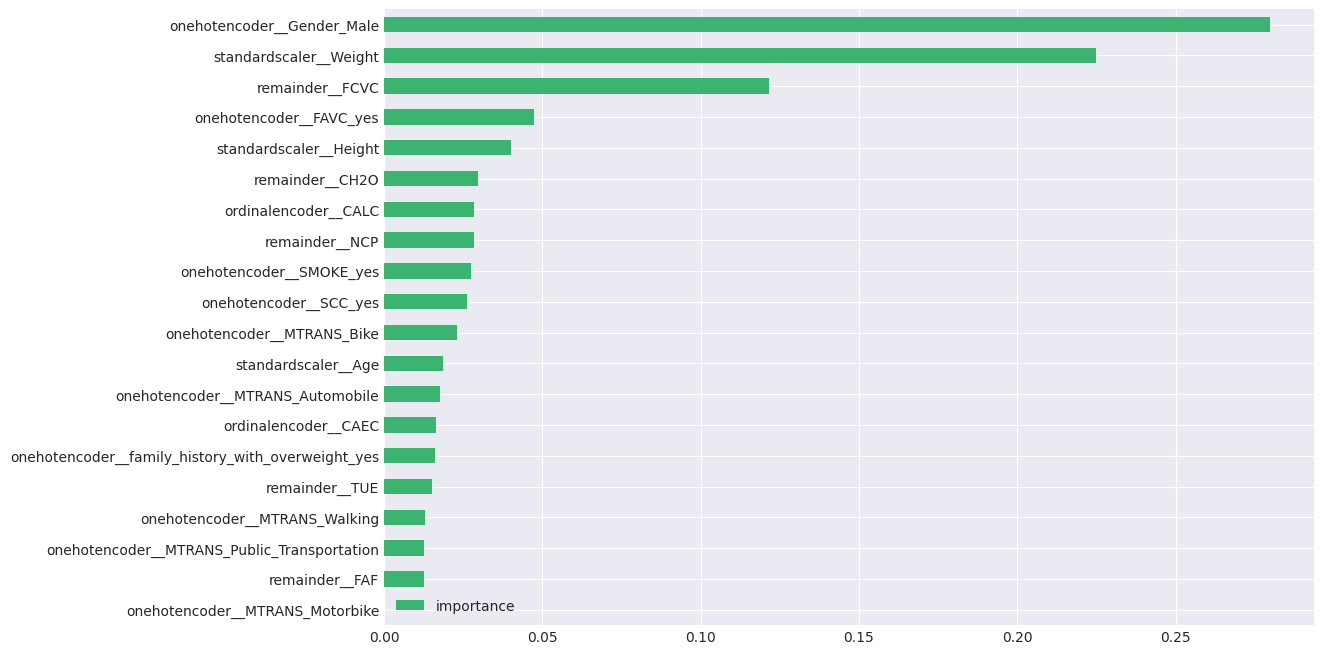

In [50]:
# Lay tam quan trong cua cac dac diem (features) tu mo hinh XGBoost da huan luyen
importance = xg_boost.feature_importances_
# Tao DataFrame chua tam quan trong cua cac dac diem voi chi so la cac cot tu X_train va sap xep cac dac diem theo thu tu tang dan cua gia tri 'importance'
feature_importance = pd.DataFrame(data=importance, index=X_train.columns, columns=['importance']).sort_values(ascending=True, by='importance')
# Ve bieu do thanh ngang (barh) the hien tam quan trong cua cac dac diem
feature_importance.plot(kind='barh', figsize=(12, 8), color='#3cb371');

In [51]:
df = pd.read_csv('data/train.csv')
# Xoa cot id
df.drop(columns='id', inplace=True)
df_org = pd.read_csv('data/ObesityDataSet.csv')
# Ghep 2 dataset
df = pd.concat([df, df_org], ignore_index=True)

In [52]:
def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    # Tao ban sao cua DataFrame dau vao
    df_copy = df.copy()
    
    # Tinh chi so BMI bang cong thuc BMI = Can nang / (Chieu cao ^ 2)
    df_copy['BMI'] = df_copy['Weight'] / (df_copy['Height'] ** 2)
    # Bien doi cot 'Age' su dung ham Box-Cox de lam bien doi nhieu tuyen tinh
    df_copy['Age'], _  = boxcox(df_copy['Age'])
    # Cat va gan nhan cot 'FCVC' vao cac nhom du lieu (bins)
    df_copy['FCVC'] = pd.cut(df_copy['FCVC'],
                              bins=[0.5, 1.5, 2.5, 3.5],
                              labels=[1, 2, 3]).astype('float64')
    # Cat va gan nhan cot 'NCP' vao cac nhom du lieu (bins)
    df_copy['NCP'] = pd.cut(df_copy['NCP'],
                              bins=[0.5, 1.5, 2.5, 3.5, 4.5],
                              labels=[1, 2, 3, 4]).astype('float64')
    # Cat va gan nhan cot 'CH2O' vao cac nhom du lieu (bins)
    df_copy['CH2O'] = pd.cut(df_copy['CH2O'],
                              bins=[0.5, 1.5, 2.5, 3.5],
                              labels=[1, 2, 3]).astype('float64')
    # Cat va gan nhan cot 'FAF' vao cac nhom du lieu (bins)
    df_copy['FAF'] = pd.cut(df_copy['FAF'],
                              bins=[-0.5, 0.5, 1.5, 2.5, 3.5],
                              labels=[0, 1, 2, 3]).astype('float64')
    # Cat va gan nhan cot 'TUE' vao cac nhom du lieu (bins)
    df_copy['TUE'] = pd.cut(df_copy['TUE'],
                              bins=[-0.5, 0.5, 1.5, 2.5],
                              labels=[0, 1, 2]).astype('float64')
    
    # Khoi tao doi tuong PolynomialFeatures voi bac 3
    poly = PolynomialFeatures(degree=3, include_bias=False)
    # Chon cac cot de bien doi
    features = df_copy[['BMI', 'Weight']]
    # Fit va bien doi cac dac diem de tao ra cac dac diem da thuc (polynomial features)
    poly_features = poly.fit_transform(features)
    # Tao DataFrame moi chua cac dac diem da thuc
    poly_feature_names = poly.get_feature_names_out(['BMI', 'Weight'])
    df_poly = pd.DataFrame(poly_features, columns=poly_feature_names)
    df_poly.drop(columns=['BMI', 'Weight'], inplace=True)
    # Ket hop DataFrame goc voi cac dac diem da thuc moi
    df_copy = pd.concat([df_copy, df_poly], axis=1)
    # Tra ve DataFrame da duoc bien doi
    return df_copy


In [53]:
# Thuc hien bien doi feature engineering cho dataFrame va hien thi sau khi bien doi
df_trans = feature_engineering(df)
df_trans

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,MTRANS,NObeyesdad,BMI,BMI^2,BMI Weight,Weight^2,BMI^3,BMI^2 Weight,BMI Weight^2,Weight^3
0,Male,0.675652,1.699998,81.669950,yes,yes,2.0,3.0,Sometimes,no,...,Public_Transportation,Overweight_Level_II,28.259565,798.603001,2307.957241,6669.980733,22568.173215,65221.867128,188490.752492,5.447370e+05
1,Female,0.672095,1.560000,57.000000,yes,yes,2.0,3.0,Frequently,no,...,Automobile,Normal_Weight,23.422091,548.594334,1335.059172,3249.000000,12849.226268,31269.877047,76098.372781,1.851930e+05
2,Female,0.672095,1.711460,50.165754,yes,yes,2.0,1.0,Sometimes,no,...,Public_Transportation,Insufficient_Weight,17.126706,293.324052,859.174110,2516.602874,5023.674734,14714.822210,43101.117041,1.262473e+05
3,Female,0.674060,1.710730,131.274851,yes,yes,3.0,3.0,Sometimes,no,...,Public_Transportation,Obesity_Type_III,44.855798,2012.042650,5888.438252,17233.086505,90251.779503,264130.599132,773003.854132,2.262271e+06
4,Male,0.677632,1.914186,93.798055,yes,yes,3.0,2.0,Sometimes,no,...,Public_Transportation,Overweight_Level_II,25.599151,655.316531,2401.150572,8798.075122,16775.546820,61467.416021,225223.253401,8.252423e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22864,Female,0.674073,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,...,Public_Transportation,Obesity_Type_III,44.901475,2016.142457,5900.436735,17268.201231,90527.770141,264938.312544,775367.705886,2.269189e+06
22865,Female,0.674595,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,...,Public_Transportation,Obesity_Type_III,43.741923,1913.355859,5850.173562,17887.174802,83693.865312,255897.843533,782419.429196,2.392283e+06
22866,Female,0.674852,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,...,Public_Transportation,Obesity_Type_III,43.543817,1896.063963,5821.344623,17872.842838,82561.861424,253483.562526,778251.790383,2.389409e+06
22867,Female,0.675622,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,...,Public_Transportation,Obesity_Type_III,44.071535,1942.300233,5876.791210,17781.326666,85600.153474,258999.211858,783650.367678,2.371080e+06


In [54]:
# Tach tinh nang va nhan muc tieu
y_trans = df_trans['NObeyesdad']
X_trans = df_trans.drop(columns='NObeyesdad')
# Ma hoa cac lop muc tieu
mapping = {'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2, 'Overweight_Level_II': 3, 'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6}
inverse_mapping = {v: k for k, v in mapping.items()}
y_trans = y_trans.map(mapping)
# Tach thanh tap huan luyen va tap du lieu
X_train_trans, X_test_trans, y_train_trans, y_test_trans = train_test_split(X_trans, y_trans, test_size=0.2, shuffle=True, stratify=y_trans, random_state=RANDOM_STATE)
display(X_train_trans)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,CALC,MTRANS,BMI,BMI^2,BMI Weight,Weight^2,BMI^3,BMI^2 Weight,BMI Weight^2,Weight^3
19926,Female,0.673566,1.741192,128.763843,yes,yes,3.0,3.0,Sometimes,no,...,Sometimes,Public_Transportation,42.471794,1803.853267,5468.831387,16580.127264,76612.883977,232271.078885,704187.746057,2.134921e+06
15522,Male,0.677889,1.720000,83.000000,yes,yes,2.0,1.0,Sometimes,no,...,no,Walking,28.055706,787.122627,2328.623580,6889.000000,22083.280847,65331.178058,193275.757166,5.717870e+05
15970,Female,0.673566,1.735461,137.796884,yes,yes,3.0,3.0,Sometimes,no,...,Sometimes,Public_Transportation,45.751957,2093.241614,6304.477179,18987.981240,95769.901363,288442.171923,868737.310566,2.616485e+06
18897,Male,0.677938,1.858265,97.582959,yes,yes,2.0,3.0,Sometimes,no,...,Sometimes,Public_Transportation,28.259124,798.578066,2757.608899,9522.433887,22567.116264,77927.610676,269095.636088,9.292273e+05
11157,Female,0.672095,1.700000,50.000000,no,yes,2.0,4.0,Sometimes,no,...,Sometimes,Public_Transportation,17.301038,299.325918,865.051903,2500.000000,5178.649101,14966.295902,43252.595156,1.250000e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19579,Female,0.673147,1.531610,62.877347,yes,no,2.0,1.0,Sometimes,no,...,no,Public_Transportation,26.803890,718.448505,1685.357476,3953.560766,19257.214504,45174.135943,105970.806822,2.485894e+05
21302,Female,0.673749,1.755978,53.699561,yes,yes,2.0,4.0,Frequently,no,...,no,Public_Transportation,17.415366,303.294957,935.197484,2883.642852,5281.992534,16286.806024,50219.694325,1.548504e+05
666,Female,0.676196,1.624950,111.886611,yes,yes,3.0,3.0,Sometimes,no,...,Sometimes,Public_Transportation,42.373869,1795.544736,4741.068547,12518.613721,76084.176630,200897.415426,530462.092282,1.400665e+06
4435,Male,0.677570,1.848294,121.310257,yes,yes,2.0,3.0,Sometimes,no,...,Sometimes,Automobile,35.510388,1260.987643,4307.774273,14716.178453,44778.160250,152970.735075,522577.204132,1.785223e+06


In [55]:
numerical_cols = [cname for cname in df_trans.columns if df_trans[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in df_trans.columns if df_trans[cname].dtype == "object" and cname != 'NObeyesdad']
print('Numerical Columns (Trường số liệu): ', numerical_cols)
print('Categorical Columns (Trường thể loại): ', categorical_cols)

Numerical Columns (Trường số liệu):  ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI', 'BMI^2', 'BMI Weight', 'Weight^2', 'BMI^3', 'BMI^2 Weight', 'BMI Weight^2', 'Weight^3']
Categorical Columns (Trường thể loại):  ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']


In [56]:
# Xoa cac truong du lieu khong can thiet
numerical_cols.remove('FCVC')
numerical_cols.remove('NCP')
numerical_cols.remove('CH2O')
numerical_cols.remove('FAF')
numerical_cols.remove('TUE')
numerical_cols

['Age',
 'Height',
 'Weight',
 'BMI',
 'BMI^2',
 'BMI Weight',
 'Weight^2',
 'BMI^3',
 'BMI^2 Weight',
 'BMI Weight^2',
 'Weight^3']

In [57]:
# Bộ mã hóa cột này chuẩn bị dữ liệu bằng cách mã hóa dữ liệu phân loại, chuẩn hóa dữ liệu số, và kết hợp chúng thành một DataFrame đầu ra có thể sử dụng được cho mô hình học máy.
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='if_binary')
oe = OrdinalEncoder(categories = [['no', 'Sometimes', 'Frequently', 'Always']] * 2)
scaler = StandardScaler()
col_trans = make_column_transformer(
    (ohe, ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'MTRANS']),
    (oe, ['CAEC', 'CALC']),
    (scaler, numerical_cols),
    remainder='passthrough',
    n_jobs=-1
)
col_trans.set_output(transform='pandas')

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['Gender', 'family_history_with_overweight',
                                  'FAVC', 'SMOKE', 'SCC', 'MTRANS']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[['no', 'Sometimes',
                                                             'Frequently',
                                                             'Always'],
                                                            ['no', 'Sometimes',
                                                             'Frequently',
                                                             'Always']]),
                                 ['CAEC', 'CALC']),
                                ('standardscaler', StandardScaler(),
                                 ['Age', 'Height', 'Weight', 'BMI', 'BMI^2',
                                  'BMI Weight', 'Weight^2', 'BMI^3',
                                  'BMI^2 Weight', 'BMI Weight^2',
                                  'Weight^3'])])

In [58]:
# Tien xu ly tap huan luyen va tap kiem tra
X_train_trans = col_trans.fit_transform(X_train_trans)
X_test_trans = col_trans.transform(X_test_trans)
display(X_train_trans)

,onehotencoder__Gender_Male,onehotencoder__family_history_with_overweight_yes,onehotencoder__FAVC_yes,onehotencoder__SMOKE_yes,onehotencoder__SCC_yes,onehotencoder__MTRANS_Automobile,onehotencoder__MTRANS_Bike,onehotencoder__MTRANS_Motorbike,onehotencoder__MTRANS_Public_Transportation,onehotencoder__MTRANS_Walking,...,standardscaler__Weight^2,standardscaler__BMI^3,standardscaler__BMI^2 Weight,standardscaler__BMI Weight^2,standardscaler__Weight^3,remainder__FCVC,remainder__NCP,remainder__CH2O,remainder__FAF,remainder__TUE
19926,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.722520,1.708461,1.812047,1.854358,1.837998,3.0,3.0,2.0,0.0,1.0
15522,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.316306,-0.468062,-0.449857,-0.432030,-0.415960,2.0,1.0,2.0,1.0,0.0
15970,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2.229086,2.473104,2.573121,2.590735,2.532387,3.0,3.0,2.0,2.0,1.0
18897,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.237717,-0.448750,-0.279185,-0.092727,0.099451,2.0,3.0,3.0,1.0,1.0
11157,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-1.239667,-1.142803,-1.132261,-1.103400,-1.060203,2.0,4.0,1.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19579,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.933866,-0.580863,-0.722969,-0.822729,-0.881994,2.0,1.0,1.0,2.0,1.0
21302,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-1.158956,-1.138678,-1.114369,-1.072221,-1.017160,2.0,4.0,2.0,3.0,2.0
666,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.868056,1.687358,1.386958,1.076916,0.779239,3.0,3.0,3.0,0.0,0.0
4435,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.330381,0.437793,0.737590,1.041631,1.333752,2.0,3.0,1.0,1.0,0.0


In [59]:
# Khai bao param_grid chua cac thong so sieu tham so (hyperparameter) de tim kiem
param_grid = [{
        'C': [1e-1, 1, 10, 100, 1000], 
        'penalty': ['l2']  # Su dung penalty 'l2' (regularization l2)
    },
{
    'penalty': [None]  # Khong su dung regularization (None)
}]

# Tao doi tuong Logistic Regression voi tham so max_iter=10000 va random_state duoc xac dinh truoc
# Sau do thuc hien viec tim kiem sieu tham so (hyperparameter search) su dung ham hyper_search
# logreg_feateng la ket qua cua viec tim kiem voi ten 'logistic_regression_feateng' va tap tham so, du lieu da duoc chuyen doi (X_train_trans, y_train_trans)
logreg_feateng = hyper_search(LogisticRegression(max_iter=10000, random_state=RANDOM_STATE), 'logistic_regression_feateng', param_grid, X_train_trans, y_train_trans)


,params,mean_fit_time,mean_score_time,mean_test_score,mean_train_score
5,{'penalty': None},8.436279,0.002321,0.874829,0.877070
3,"{'penalty': 'l2', 'C': 100}",6.145500,0.000795,0.873681,0.876182
4,"{'penalty': 'l2', 'C': 1000}",7.068471,0.000531,0.873244,0.876961
2,"{'penalty': 'l2', 'C': 10}",4.889867,0.005881,0.873025,0.875635
1,"{'penalty': 'l2', 'C': 1}",3.210219,0.002853,0.871440,0.873586
0,"{'penalty': 'l2', 'C': 0.1}",2.047519,0.000758,0.865701,0.867450


## 6. Đánh giá kết quả

Các thuật ngữ **accuracy**, **f1**, **precision**, và **recall** trong học máy được sử dụng để đánh giá hiệu suất của mô hình phân loại:

1. **Accuracy (Độ chính xác)**: Tỷ lệ phần trăm các dự đoán đúng so với tổng số dự đoán. Công thức tính là:
   $$
   \text{Accuracy} = \frac{\text{Số dự đoán đúng}}{\text{Tổng số dự đoán}}
   $$

2. **F1 Score (Điểm F1)**: Là trung bình điều hòa của **precision** và **recall**. F1 Score cân bằng giữa độ chính xác và khả năng thu hồi, đặc biệt hữu ích khi dữ liệu bị mất cân bằng (một lớp có số lượng mẫu lớn hơn rất nhiều so với lớp còn lại). Công thức tính F1 Score:
   $$
   F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
   $$

3. **Precision (Độ chính xác)**: Tỷ lệ các dự đoán đúng trên tổng số dự đoán là dương (positive). Precision cho biết mô hình có chính xác khi dự đoán lớp dương không. Công thức tính là:
   $$
   \text{Precision} = \frac{\text{Số dự đoán đúng là dương}}{\text{Tổng số dự đoán là dương}}
   $$

4. **Recall (Khả năng thu hồi)**: Tỷ lệ các mẫu thực sự thuộc lớp dương mà mô hình đã dự đoán đúng. Recall cho biết mô hình có thể phát hiện được bao nhiêu mẫu dương. Công thức tính là:
   $$
   \text{Recall} = \frac{\text{Số dự đoán đúng là dương}}{\text{Tổng số mẫu thực sự là dương}}
   $$

Tóm lại:
- **Accuracy**: Độ chính xác chung.
- **F1 Score**: Cân bằng giữa precision và recall.
- **Precision**: Tính chính xác khi dự đoán lớp dương.
- **Recall**: Khả năng phát hiện lớp dương.

In [60]:
# Du doan ket qua tu mo hinh Voting Classifier va in ra cac so lieu danh gia (accuracy, f1, precision, recall)
y_pred = votingClf.predict(X_test)
model_name = 'Voting Classifier'
print(f'Accuracy of {model_name}', accuracy_score(y_test, y_pred))
print(f'F1_score of {model_name}', f1_score(y_test, y_pred, average='weighted'))
print(f'Precision_score of {model_name}', precision_score(y_test, y_pred, average='weighted'))
print(f'Recall_score of {model_name}', recall_score(y_test, y_pred, average='weighted'))

Accuracy of Voting Classifier 0.9145168342807171
F1_score of Voting Classifier 0.9140900013767821
Precision_score of Voting Classifier 0.9141084775516108
Recall_score of Voting Classifier 0.9145168342807171


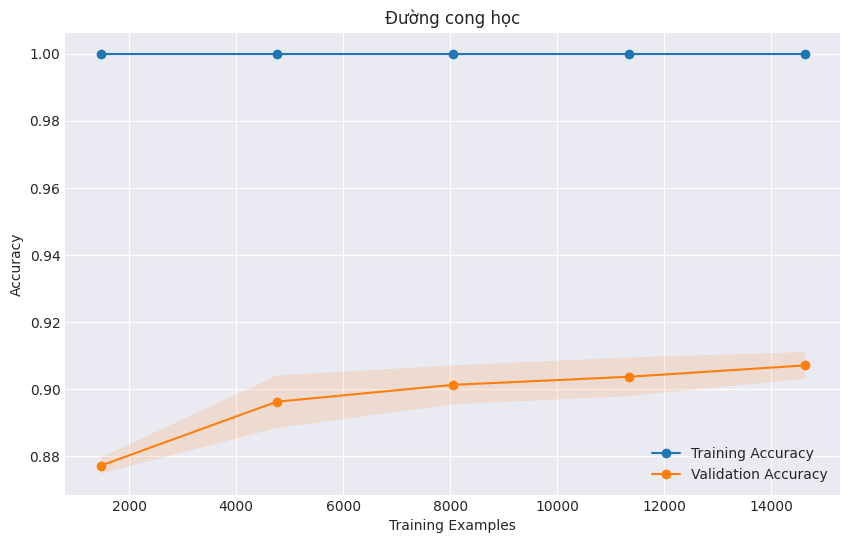

In [61]:
# Ve duong cong hoc
train_sizes, train_scores, test_scores = learning_curve(votingClf, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy', marker='o', linestyle='-')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15)
plt.plot(train_sizes, test_mean, label='Validation Accuracy', marker='o', linestyle='-')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15)

plt.title('Đường cong học')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)

plt.show()

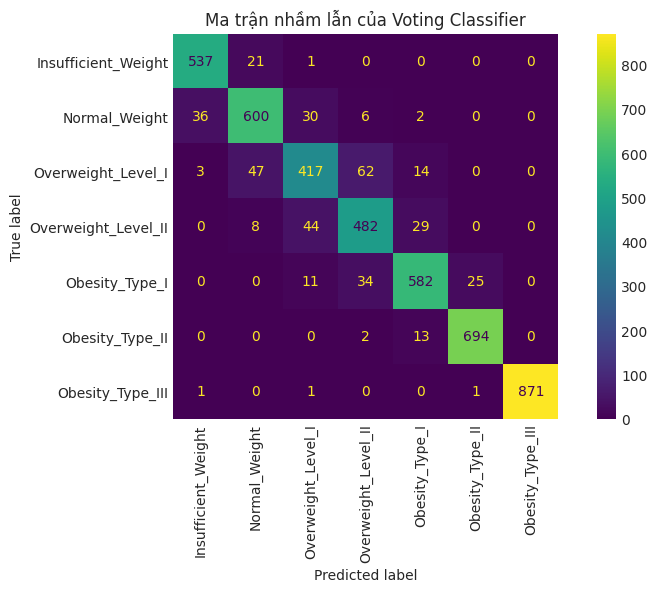

In [62]:
target_names = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']
fig, ax = plt.subplots(figsize=(10, 5))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
ax.xaxis.set_ticklabels(target_names, rotation=90)  
ax.yaxis.set_ticklabels(target_names)
ax.grid(False)  
_ = ax.set_title("Ma trận nhầm lẫn của Voting Classifier")
plt.show()

In [63]:
print(classification_report(y_test, y_pred, target_names=target_names))

                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.96      0.95       559
      Normal_Weight       0.89      0.89      0.89       674
 Overweight_Level_I       0.83      0.77      0.80       543
Overweight_Level_II       0.82      0.86      0.84       563
     Obesity_Type_I       0.91      0.89      0.90       652
    Obesity_Type_II       0.96      0.98      0.97       709
   Obesity_Type_III       1.00      1.00      1.00       874

           accuracy                           0.91      4574
          macro avg       0.91      0.91      0.91      4574
       weighted avg       0.91      0.91      0.91      4574



In [64]:
df_results

,params,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,model_name
0,"{'p': 1, 'n_neighbors': 20}",0.008595,1.546251,0.829735,0.848401,knn
1,{'penalty': None},2.194579,0.001171,0.870456,0.872451,logistic_regression
2,"{'min_samples_leaf': 10, 'max_depth': 10, 'cri...",0.098804,0.003331,0.883083,0.907092,decision_tree
3,"{'n_estimators': 500, 'min_samples_leaf': 10, ...",13.941316,0.282363,0.896529,0.922165,random_forest
4,"{'n_estimators': 500, 'max_depth': 15}",15.425583,0.737314,0.905712,1.000000,xg_boost
5,"XGBClassifier(n_estimators = 500, max_depth = ...",17.442886,0.615570,0.907078,1.000000,voting_classifier
6,{'penalty': None},8.436279,0.002321,0.874829,0.877070,logistic_regression_feateng


In [65]:
df_results.to_csv('result_report_new.csv')